In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')
from typing import List
from tqdm import tqdm
import copy

# Loading and Preprocessing the dataset

In [2]:
train_df=pd.read_csv('~/Programming/COMP551/COMP551_A3/dataset/sign_mnist_train.csv')
test_df=pd.read_csv('~/Programming/COMP551/COMP551_A3/dataset/sign_mnist_test.csv')

In [3]:
train_df.describe()

label        pixel1        pixel2        pixel3        pixel4  \
count  27455.000000  27455.000000  27455.000000  27455.000000  27455.000000   
mean      12.318813    145.419377    148.500273    151.247714    153.546531   
std        7.287552     41.358555     39.942152     39.056286     38.595247   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        6.000000    121.000000    126.000000    130.000000    133.000000   
50%       13.000000    150.000000    153.000000    156.000000    158.000000   
75%       19.000000    174.000000    176.000000    178.000000    179.000000   
max       24.000000    255.000000    255.000000    255.000000    255.000000   

             pixel5        pixel6        pixel7        pixel8        pixel9  \
count  27455.000000  27455.000000  27455.000000  27455.000000  27455.000000   
mean     156.210891    158.411255    160.472154    162.339683    163.954799   
std       37.111165     36.125579     35.016392     33.661998     32.651607   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%      137.000000    140.000000    142.000000    144.000000    146.000000   
50%      160.000000    162.000000    164.000000    165.000000    166.000000   
75%      181.000000    182.000000    183.000000    184.000000    185.000000   
max      255.000000    255.000000    255.000000    255.000000    255.000000   

       ...      pixel775      pixel776      pixel777      pixel778  \
count  ...  27455.000000  27455.000000  27455.000000  27455.000000   
mean   ...    141.104863    147.495611    153.325806    159.125332   
std    ...     63.751194     65.512894     64.427412     63.708507   
min    ...      0.000000      0.000000      0.000000      0.000000   
25%    ...     92.000000     96.000000    103.000000    112.000000   
50%    ...    144.000000    162.000000    172.000000    180.000000   
75%    ...    196.000000    202.000000    205.000000    207.000000   
max    ...    255.000000    255.000000    255.000000    255.000000   

           pixel779      pixel780      pixel781      pixel782      pixel783  \
count  27455.000000  27455.000000  27455.000000  27455.000000  27455.000000   
mean     161.969259    162.736696    162.906137    161.966454    161.137898   
std       63.738316     63.444008     63.509210     63.298721     63.610415   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%      120.000000    125.000000    128.000000    128.000000    128.000000   
50%      183.000000    184.000000    184.000000    182.000000    182.000000   
75%      208.000000    207.000000    207.000000    206.000000    204.000000   
max      255.000000    255.000000    255.000000    255.000000    255.000000   

           pixel784  
count  27455.000000  
mean     159.824731  
std       64.396846  
min        0.000000  
25%      125.500000  
50%      182.000000  
75%      204.000000  
max      255.000000  

[8 rows x 785 columns]

The train_df dataset consit of 1st column representing labels 1 to 24. The label is loaded in a separate dataframe called 'train_label' and the 'label' column is dropped from the original training dataframe which now consist of only 784 pixel values for each image.

In [4]:
# Drop the label column for the train_df
train_label = train_df['label']
trainset = train_df.drop(['label'], axis=1)
# Convert the dataframe to numpy array
X_train = trainset.values.astype(np.float64)

# Same thing for the test_df
test_label = test_df['label']
testset = test_df.drop(['label'], axis=1)
# Convert the dataframe to numpy array
X_test = testset.values.astype(np.float64)

One-hot encodding

In [5]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
y_train = lb.fit_transform(train_label)
y_test = lb.fit_transform(test_label)

# Normalizatioin and Vectorization

In [6]:
X_train_mean = np.mean(X_train)
X_train_std = np.std(X_train, axis=0)
# For images, subtract a single data from all pixels
X_train -= X_train_mean
X_train /= X_train_std + 1e-5

X_test -= X_train_mean
X_test /= X_train_std + 1e-5

# Vectorization
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

In [7]:
X_test.shape

(7172, 784)

In [8]:
half = int(X_test.shape[0]/2)

In [9]:
#Following the Ed discussions, using half of the testing set as the validation set

X_validation = X_test[:half]
y_validation = y_test[:half]

X_test = X_test[half:]
y_test = y_test[half:]

In [10]:
X_validation.shape

(3586, 784)

In [11]:
X_test.shape

(3586, 784)

# MLP Implementation

In [12]:
class NeuralNetlayer:
  def __init__(self):
    self.gradient = None
    self.parameters = None

  def forward(self, x):
    raise NotImplementedError

  def backward(self, gradient):
    raise NotImplementedError

In [13]:
class LinearLayer(NeuralNetlayer):
  def __init__(self, input_size, output_size):
    super().__init__()
    self.ni = input_size
    self.no = output_size
    # For a layer with ReLU activation
    # He initialization
    std = np.sqrt(2. / input_size)
    self.w = np.random.randn(output_size, input_size) * std
    self.b = np.random.randn(output_size)
    self.cur_input = None
    self.parameters = [self.w, self.b]

  def forward(self, x):
    self.cur_input = x
    return x @ self.w.T + self.b

  def backward(self, gradient):
    assert self.cur_input is not None, "Must call forward before backward!"
    dw = gradient.T @ self.cur_input
    db = gradient.sum(axis=0)
    self.gradient = [dw, db]
    return gradient.dot(self.w)

In [14]:
class ReLULayer(NeuralNetlayer):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        self.gradient = np.where(x > 0, 1.0, 0.0)
        return np.maximum(0, x)

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient

In [15]:
class LeakyReLULayer(NeuralNetlayer):
    def __init__(self, alpha = 0.1):
        super().__init__()
        self.alpha = alpha

    def forward(self, x):
        self.gradient = np.where(x > 0, 1.0, self.alpha)
        return np.maximum(x, 0) + self.alpha * np.minimum(x, 0)

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient

In [16]:
class SigmoidLayer(NeuralNetlayer):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        sigmoid = 1 / (1 + np.exp(-x))
        self.gradient = sigmoid * (1 - sigmoid)
        return sigmoid

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient

In [17]:
class SoftmaxOutputLayer(NeuralNetlayer):
    def __init__(self):
        super().__init__()
        self.cur_probs = None

    def forward(self, x):
        x_exp_shifted = x - np.max(x, axis=1, keepdims=True)  # Improve numerical stability
        exps = np.exp(x_exp_shifted)
        probs = exps / np.sum(exps, axis=-1, keepdims=True)
        self.cur_probs = probs
        return probs


    def backward(self, target):
        assert self.cur_probs is not None, "Must call forward before backward"
        return self.cur_probs - target

In [18]:
class MLP:
    def __init__(self, *args: List[NeuralNetlayer]):
        self.layers = args

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, target):
        for layer in self.layers[::-1]:
            target = layer.backward(target)

    def predict(self, x):
        return self.forward(x)

    def fit(self, x, y, optimizer, epochs, lr):
        for epoch in range(epochs):
            y_pred = self.forward(x)
            loss = -np.sum(y * np.log(y_pred)) / len(y)
            print(f"Epoch {epoch+1}/{epochs} Loss: {loss}")
            self.backward(y)
            optimizer.step()

In [19]:
class Optimizer:
    def __init__(self, net: MLP):
        self.net = net

    def step(self):
        for layer in self.net.layers[::-1]:
            if layer.parameters is not None:
                self.update(layer.parameters, layer.gradient)

    def update(self, params, gradient):
        raise NotImplementedError

class GradientDescentOptimizer(Optimizer):
    def __init__(self, net: MLP, lr: float, lamda: float = 0.0, clip_value: float = None):
        super().__init__(net)
        self.lr = lr
        self.lamda = lamda
        self.clip_value = clip_value  # Clip value threshold

    def clip_gradient(self, gradient):
        """Clip the gradients to the specified range [-clip_value, clip_value]."""
        if self.clip_value is not None:
            np.clip(gradient, -self.clip_value, self.clip_value, out=gradient)
        return gradient

    def update(self, params, gradients):
        w, b = params
        dw, db = gradients

        # Clip gradients if clip_value is specified
        dw_clipped = self.clip_gradient(dw)
        db_clipped = self.clip_gradient(db)

        # Apply updates with potentially clipped gradients
        w -= self.lr * (dw_clipped + self.lamda * w)
        b -= self.lr * db_clipped

In [20]:
def train(mlp: MLP, optimizer: Optimizer, data_x, data_y, steps, X_test, y_test):
    losses = []
    training_accuracies = []
    testing_accuracies = []
    labels = data_y
    for _ in tqdm(range(steps)):
        predictions = mlp.forward(data_x)
        loss = -(labels * np.log(predictions)).sum(axis=-1).mean()
        losses.append(loss)

        training_accuracy = evaluate_acc(mlp, data_x, data_y) * 100
        training_accuracies.append(training_accuracy)


        #to calculate the testing accuracy in each epoch but to make sure the model doesn't actually learn anything from the testing set, create a copy
        mlp_copy = copy.deepcopy(mlp)
        predictions = mlp_copy.forward(X_test)
        testing_accuracy = np.mean(np.argmax(predictions, axis=-1) == np.argmax(y_test, axis=-1)) * 100
        testing_accuracies.append(testing_accuracy)

        mlp.backward(labels)
        optimizer.step()

    #plot the cross entropy loss and Training & Teesting Accuracies Plots
    plt.subplot(2, 1, 1)
    plt.plot(losses)
    plt.title("Cross Entropy Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Cross entropy loss")

    plt.subplot(2, 1, 2)
    plt.plot(training_accuracies, label="Training Accuracies")
    plt.plot(testing_accuracies, label="Testing Accuracies")
    plt.title("Training & Testing Accuracies")

    plt.subplots_adjust(hspace=0.5)

    plt.xlabel("Epoch")
    plt.legend()

    plt.show()

In [21]:
def train_sgd(mlp, optimizer, X_train, y_train, epochs):
    for epoch in range(epochs):
        # Shuffle the training data
        perm = np.random.permutation(X_train.shape[0])
        X_train_shuffled = X_train[perm]
        y_train_shuffled = y_train[perm]

        for i in range(X_train.shape[0]):
            # Select a single training example
            X_mini = X_train_shuffled[i:i+1]
            y_mini = y_train_shuffled[i:i+1]

            # Perform a forward pass and compute the loss
            predictions = mlp.forward(X_mini)
            loss = -(y_mini * np.log(predictions)).sum()  # Example for cross-entropy loss

            # Backward pass to compute gradients
            mlp.backward(y_mini)

            # Update model parameters
            optimizer.step()

        # Optionally print the loss here to monitor training progress
        print(f"Epoch {epoch+1}, Loss: {loss}")

In [22]:
def evaluate_acc(mlp: MLP, data_x, data_y):
    predictions = mlp.forward(data_x)
    return np.mean(np.argmax(predictions, axis=-1) == np.argmax(data_y, axis=-1))

# Experiment 1

# No Hidden Layer MLP

In [77]:
class MultiClass_Regression:
  def __init__(self, nFeatures, nClasses, learningRate = 0.005, nIter = 1000):
    std = np.sqrt(2. / nFeatures)
    self.W = np.random.rand(nFeatures, nClasses) * std
    self.learningRate = learningRate
    self.nIter = nIter

  def predict(self, X):
    matmul_result = np.matmul(X, self.W)
    matmul_result -= np.max(matmul_result, axis=1, keepdims=True)  # Improves numerical stability
    y_pred = np.exp(matmul_result)
    y_pred = y_pred / np.sum(y_pred, axis=1, keepdims=True)
    return y_pred

  def grad(self, X, y):
    return np.matmul(X.transpose(), self.predict(X) - y)

  def ce(self, X, y):
    preds = self.predict(X) + 1e-9
    return -np.sum(y * np.log(preds))
    #return -np.sum(y * np.log(self.predict(X)) + 1e-9)

  def fit(self, X, y, X_test=None, y_test=None):
    losses_train = np.zeros(self.nIter)
    training_accuracies = []
    testing_accuracies = []
    for i in range(self.nIter):
      predicted = self.predict(X)
      training_accuracy = self.evaluate(predicted, y)
      training_accuracies.append(training_accuracy)

      if X_test is not None and y_test is not None and X_test.size > 0 and y_test.size > 0:
        test_predicted = self.predict(X_test)
        testing_accuracy = self.evaluate(test_predicted, y_test)
        testing_accuracies.append(testing_accuracy)

      grad = self.grad(X, y)

      loss_train = self.ce(X, y)
      losses_train[i] = loss_train
      self.W = self.W - self.learningRate * grad

    if X_test is not None and y_test is not None and X_test.size > 0 and y_test.size > 0:
      plt.clf()
      plt.plot(training_accuracies, label = "Training Accuracies")
      plt.plot(testing_accuracies, label = "Testing Accuracies")
      plt.title('MultiClass Regression Training & Testing Accuracies')
      plt.xlabel("iteration")
      plt.ylabel("Accuracies")
      plt.show()

    return losses_train

  def evaluate(self, y, y_pred):
        accuracy = sum(y_pred.argmax(axis=1) == y.argmax(axis=1))
        accuracy = accuracy / y.shape[0]
        return accuracy

In [74]:
def evaluate(y, y_pred):
    accuracy = sum(y_pred.argmax(axis=1) == y.argmax(axis=1))
    accuracy = accuracy / y.shape[0]
    return accuracy

# Decide on the Learning Rate

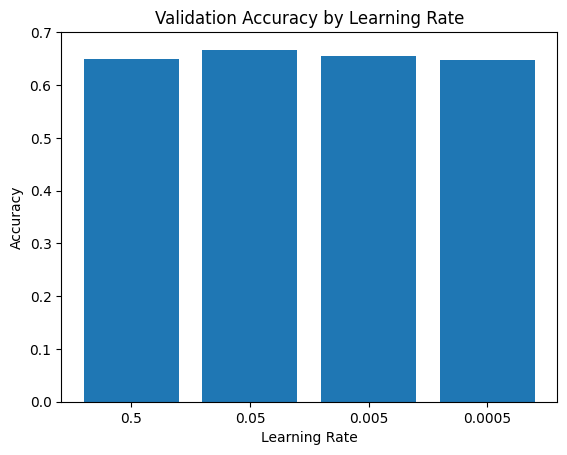

In [79]:
LEARNING_RATES  = [0.5, 0.05, 0.005, 0.0005]
validation_accuracy_list = []

for LEARNING_RATE in LEARNING_RATES:
  mlr = MultiClass_Regression(X_train.shape[1], y_train.shape[1], learningRate = LEARNING_RATE, nIter = 400)
  ce_train = mlr.fit(X_train, y_train)
  validation_accuracy = evaluate(mlr.predict(X_validation), y_validation)
  validation_accuracy_list.append(validation_accuracy)

learning_rate_str = [str(lr) for lr in LEARNING_RATES]

plt.bar(learning_rate_str, validation_accuracy_list)

plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy by Learning Rate')
plt.xticks(learning_rate_str, LEARNING_RATES)

plt.show()

In [80]:
print(validation_accuracy_list)

[0.6500278862242053, 0.6673173452314557, 0.6553262688232013, 0.6477969882877859]


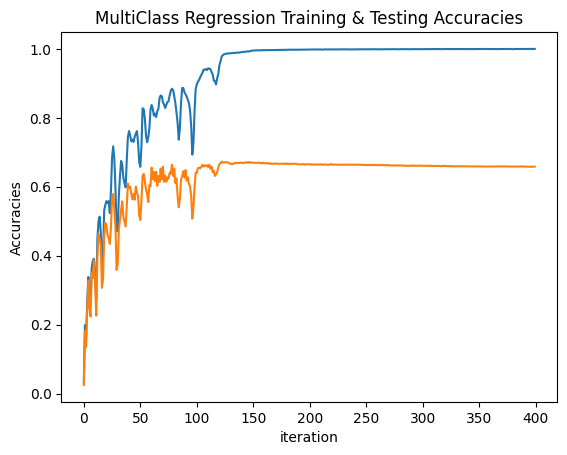

In [81]:
mlr = MultiClass_Regression(X_train.shape[1], y_train.shape[1], learningRate = 0.05, nIter = 400)
ce_train = mlr.fit(X_train, y_train, X_test, y_test)

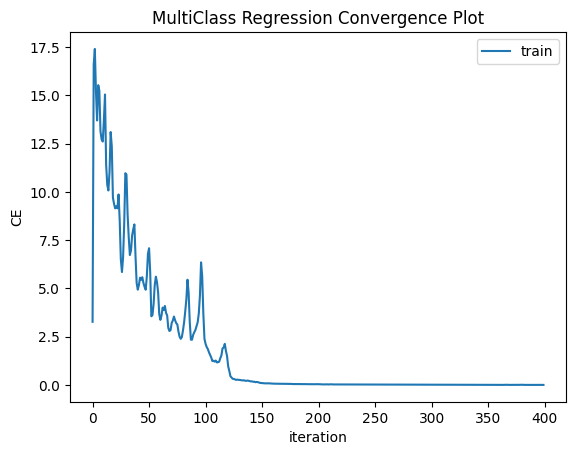

In [82]:
plt.clf()
plt.plot(ce_train/X_train.shape[0], label='train')
plt.title('MultiClass Regression Convergence Plot')
plt.xlabel("iteration")
plt.ylabel("CE")
plt.legend()
plt.show()

In [83]:
#best model test accuracy for no hidden layer MLP (multiclass regression)

training_accuracy = evaluate(mlr.predict(X_train), y_train)
test_accuracy = evaluate(mlr.predict(X_test), y_test)
print("Training Classification Accuracy is:", training_accuracy)
print("Test Classification Accuracy is:", test_accuracy)

Training Classification Accuracy is: 0.999745037333819
Test Classification Accuracy is: 0.658393753485778


# 1 Hidden Layer MLP

Hidden Unit Size: 32


100%|██████████| 200/200 [02:26<00:00,  1.37it/s]


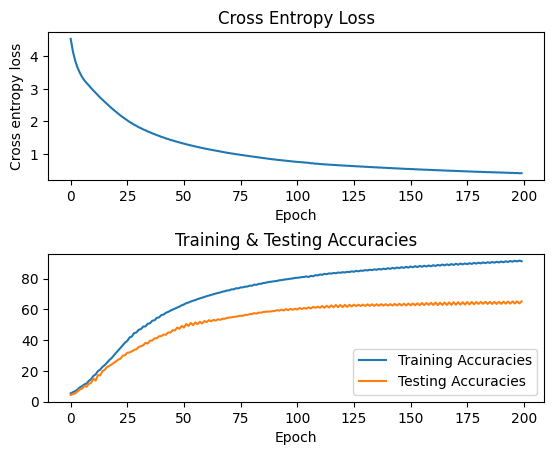

Training accuracy:  0.9194317974867966
Test accuracy: 0.6402677077523703


Hidden Unit Size: 64


100%|██████████| 200/200 [03:17<00:00,  1.01it/s]


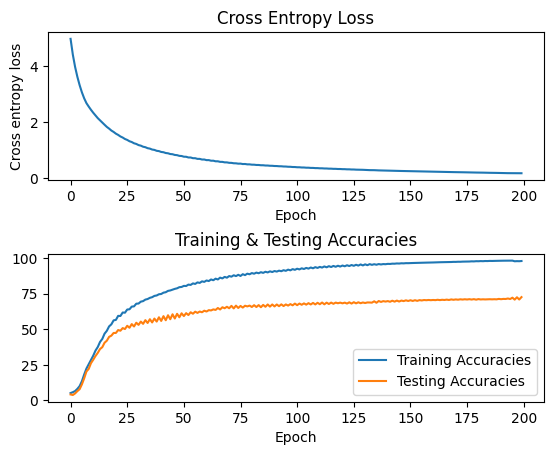

Training accuracy:  0.97756328537607
Test accuracy: 0.7105409927495817


Hidden Unit Size: 128


100%|██████████| 200/200 [04:42<00:00,  1.41s/it]


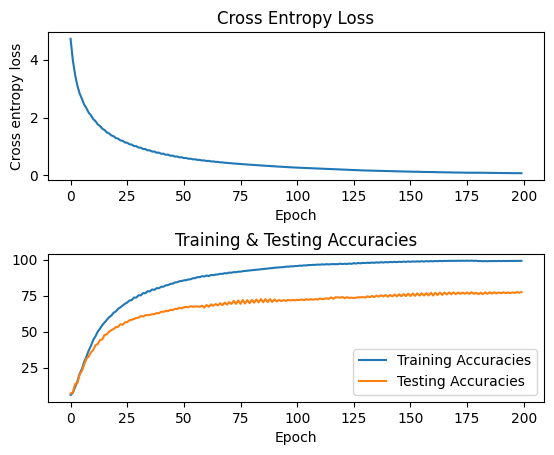

Training accuracy:  0.9917319249681297
Test accuracy: 0.771611823759063


Hidden Unit Size: 256


100%|██████████| 200/200 [07:59<00:00,  2.40s/it]


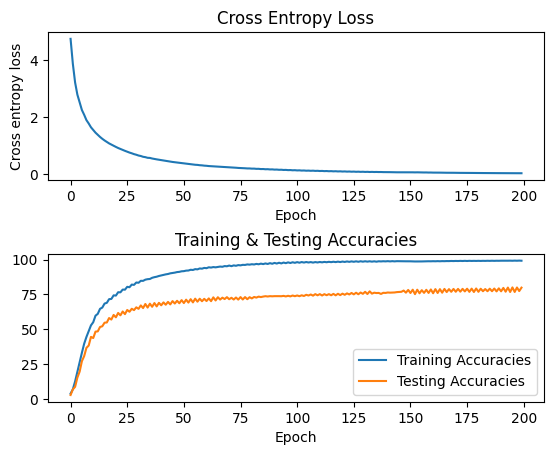

Training accuracy:  0.9930795847750865
Test accuracy: 0.7774679308421639




In [84]:
n_features = X_train.shape[-1]
HIDDEN_SIZE_LIST = [32, 64, 128, 256]
OUTPUT_SIZE = 24
GRADIENT_STEPS = 200

for HIDDEN_SIZE in HIDDEN_SIZE_LIST:
  print("Hidden Unit Size:", HIDDEN_SIZE)
  mlp2 = MLP(
      LinearLayer(n_features, HIDDEN_SIZE),
      ReLULayer(),
      LinearLayer(HIDDEN_SIZE, OUTPUT_SIZE),
      SoftmaxOutputLayer()
  )
  opt2 = GradientDescentOptimizer(mlp2, 1e-3, clip_value=1.0)

  train(mlp2, opt2, X_train, y_train, GRADIENT_STEPS, X_test, y_test)
  print("Training accuracy: ", evaluate_acc(mlp2, X_train, y_train))
  print("Test accuracy:", evaluate_acc(mlp2, X_test, y_test))
  print()
  print()

  # mlp2.fit(X_train, y_train, opt2, GRADIENT_STEPS, 1e-3)

# Deciding on Learning Rate

100%|██████████| 200/200 [08:11<00:00,  2.46s/it]


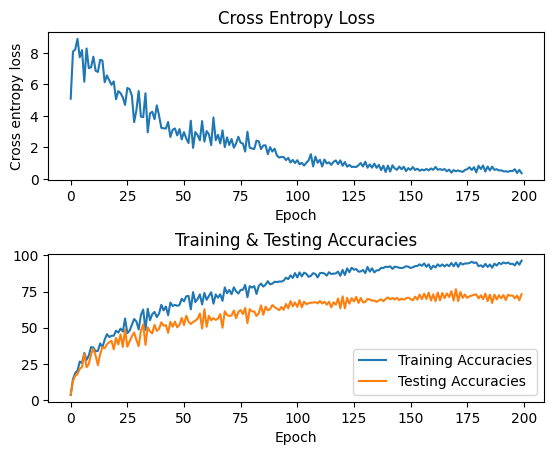

100%|██████████| 200/200 [08:03<00:00,  2.42s/it]


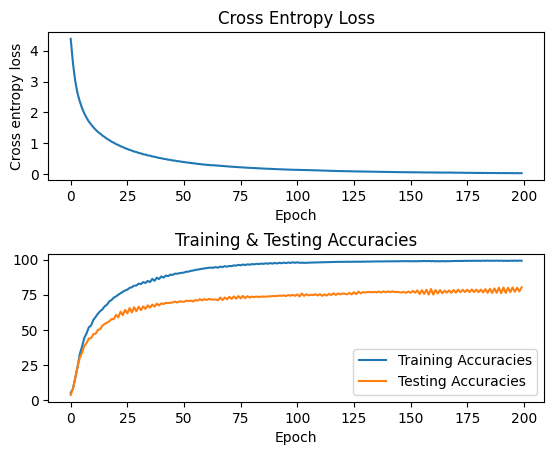

100%|██████████| 200/200 [08:15<00:00,  2.48s/it]


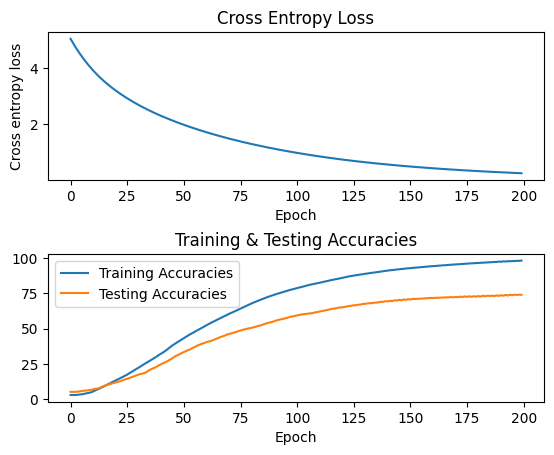

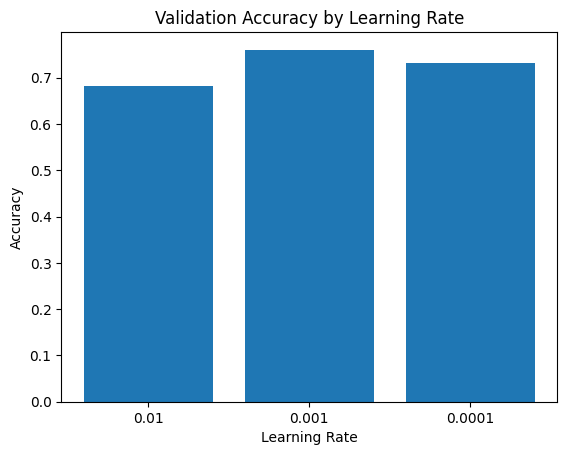

In [85]:
n_features = X_train.shape[-1]
HIDDEN_SIZE = 256
OUTPUT_SIZE = 24
GRADIENT_STEPS = 200
LEARNING_RATES = [0.01, 0.001, 0.0001]
validation_accuracy_list = []

for LEARNING_RATE in LEARNING_RATES:
  mlp2 = MLP(
    LinearLayer(n_features, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, OUTPUT_SIZE),
    SoftmaxOutputLayer()
  )

  opt2 = GradientDescentOptimizer(mlp2, LEARNING_RATE, clip_value=1.0)

  train(mlp2, opt2, X_train, y_train, GRADIENT_STEPS, X_test, y_test)

  validation_accuracy = evaluate_acc(mlp2, X_validation, y_validation)
  validation_accuracy_list.append(validation_accuracy)


learning_rate_str = [str(lr) for lr in LEARNING_RATES]

plt.bar(learning_rate_str, validation_accuracy_list)

plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy by Learning Rate')
plt.xticks(learning_rate_str, LEARNING_RATES)

plt.show()

# Deciding on Clip Value

100%|██████████| 200/200 [08:14<00:00,  2.47s/it]


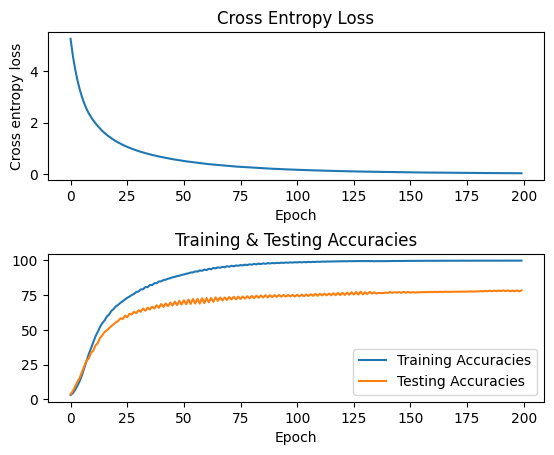

100%|██████████| 200/200 [08:18<00:00,  2.49s/it]


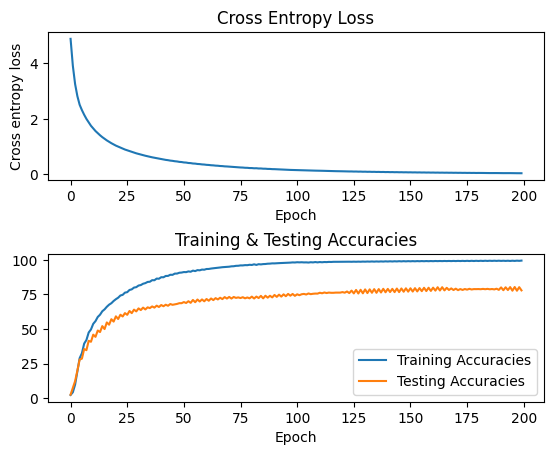

100%|██████████| 200/200 [08:13<00:00,  2.47s/it]


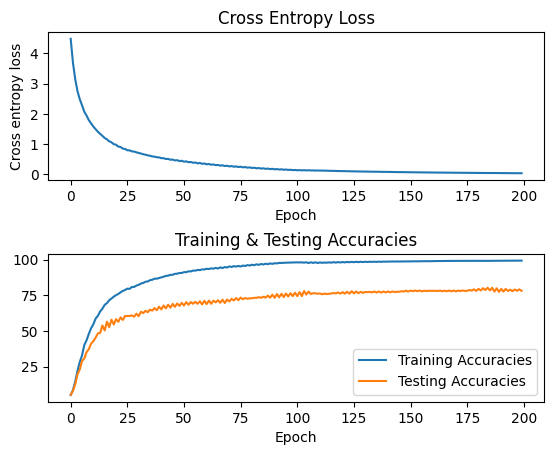

100%|██████████| 200/200 [08:06<00:00,  2.43s/it]


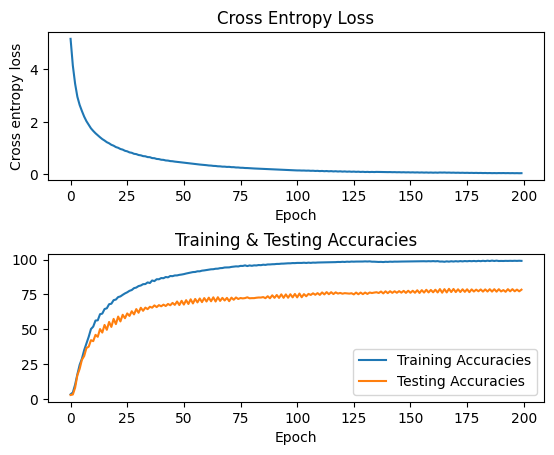

100%|██████████| 200/200 [08:09<00:00,  2.45s/it]


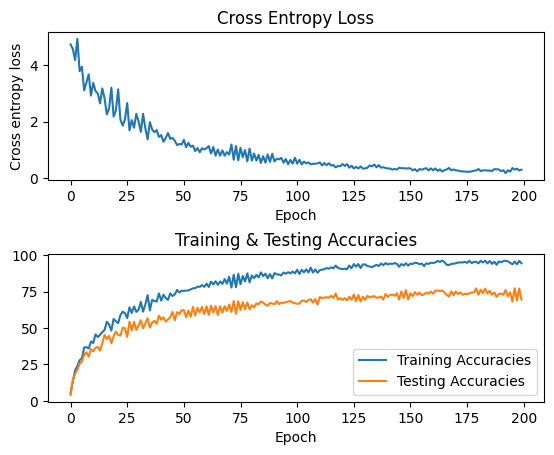

In [88]:
n_features = X_train.shape[-1]
HIDDEN_SIZE = 256
OUTPUT_SIZE = 24
GRADIENT_STEPS = 200
LEARNING_RATE = 0.001
validation_accuracy_list = []
CLIP_VALUES = [0.5, 0.9, 0.98, 1.0, 5.0]

for CLIP_VALUE in CLIP_VALUES:
  mlp2 = MLP(
    LinearLayer(n_features, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, OUTPUT_SIZE),
    SoftmaxOutputLayer()
  )

  opt2 = GradientDescentOptimizer(mlp2, LEARNING_RATE, clip_value=CLIP_VALUE)

  train(mlp2, opt2, X_train, y_train, GRADIENT_STEPS, X_test, y_test)

  validation_accuracy = evaluate_acc(mlp2, X_validation, y_validation)
  validation_accuracy_list.append(validation_accuracy)

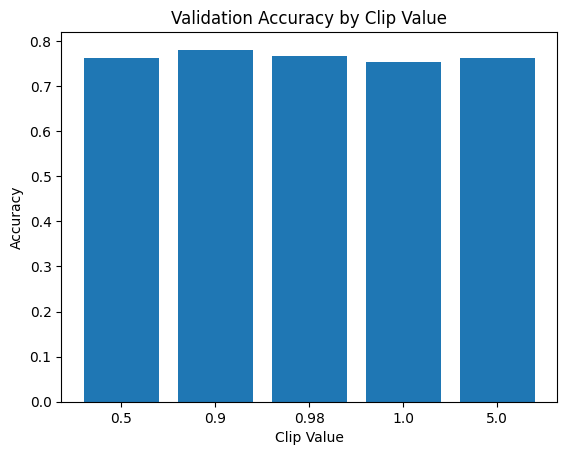

In [89]:
clip_value_str = [str(lr) for lr in CLIP_VALUES]

plt.bar(clip_value_str, validation_accuracy_list)

plt.xlabel('Clip Value')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy by Clip Value')
plt.xticks(clip_value_str, CLIP_VALUES)

plt.show()

In [90]:
#best model test accuracy for 1 Hidden Layer MLP

opt2 = GradientDescentOptimizer(mlp2, LEARNING_RATE, clip_value=0.9)
print("Test accuracy:", evaluate_acc(mlp2, X_test, y_test))

Test accuracy: 0.7746793084216397


# 2 Hidden Layer MLP

Hidden Unit Size: 32


100%|██████████| 200/200 [02:23<00:00,  1.40it/s]


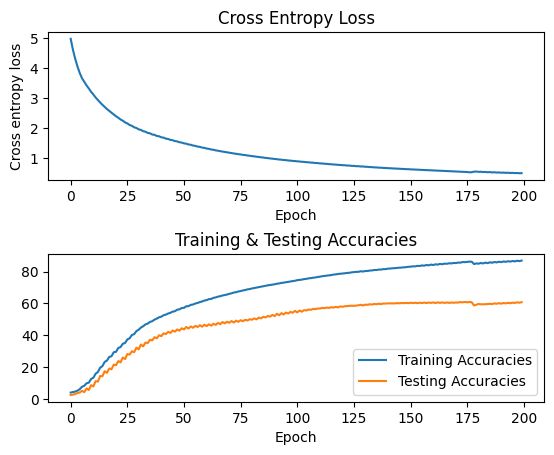

Training accuracy:  0.8671280276816609
Test accuracy: 0.6065253764640268


Hidden Unit Size: 64


100%|██████████| 200/200 [03:24<00:00,  1.02s/it]


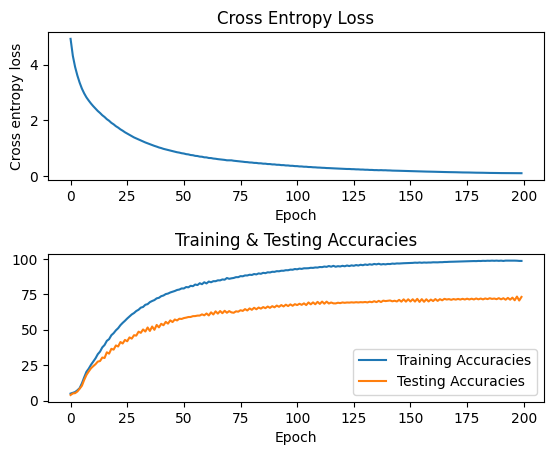

Training accuracy:  0.9861955927881989
Test accuracy: 0.7064974902398216


Hidden Unit Size: 128


100%|██████████| 200/200 [05:22<00:00,  1.61s/it]


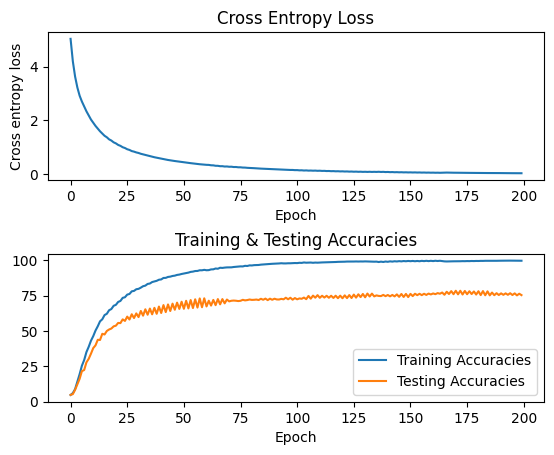

Training accuracy:  0.9975596430522673
Test accuracy: 0.7639431121026213


Hidden Unit Size: 256


100%|██████████| 200/200 [10:43<00:00,  3.22s/it]


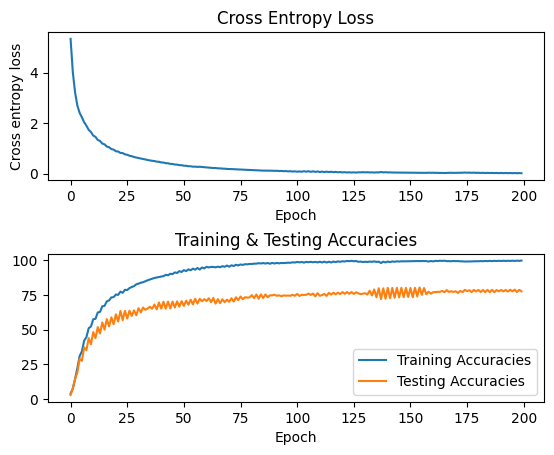

Training accuracy:  0.9951557093425606
Test accuracy: 0.7844394868934746




In [38]:
n_features = X_train.shape[-1]
HIDDEN_SIZE_LIST = [32, 64, 128, 256]
OUTPUT_SIZE = 24
GRADIENT_STEPS = 200

for HIDDEN_SIZE in HIDDEN_SIZE_LIST:
  print("Hidden Unit Size:", HIDDEN_SIZE)
  mlp2 = MLP(
      LinearLayer(n_features, HIDDEN_SIZE),
      ReLULayer(),
      LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
      ReLULayer(),
      LinearLayer(HIDDEN_SIZE, OUTPUT_SIZE),
      SoftmaxOutputLayer()
  )
  opt2 = GradientDescentOptimizer(mlp2, 1e-3, clip_value=1.0)

  train(mlp2, opt2, X_train, y_train, GRADIENT_STEPS, X_test, y_test)
  print("Training accuracy: ", evaluate_acc(mlp2, X_train, y_train))
  print("Test accuracy:", evaluate_acc(mlp2, X_test, y_test))
  print()
  print()

  # mlp2.fit(X_train, y_train, opt2, GRADIENT_STEPS, 1e-3)

# Deciding on Learning Rate

100%|██████████| 200/200 [11:36<00:00,  3.48s/it]


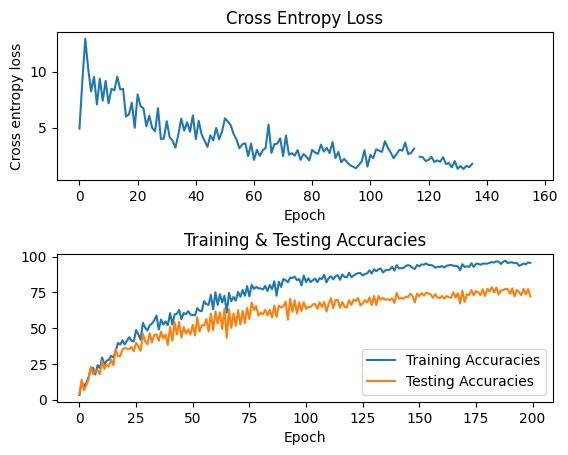

100%|██████████| 200/200 [11:40<00:00,  3.50s/it]


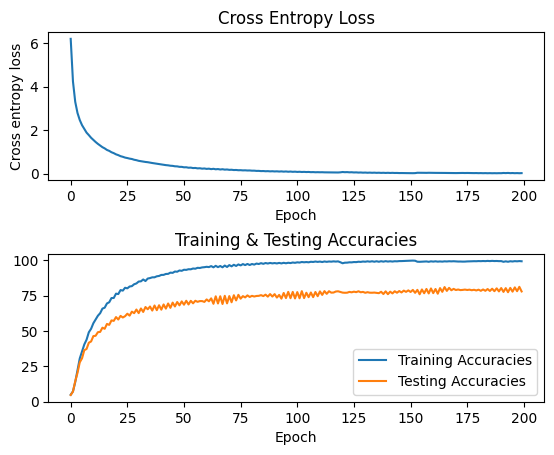

100%|██████████| 200/200 [11:31<00:00,  3.46s/it]


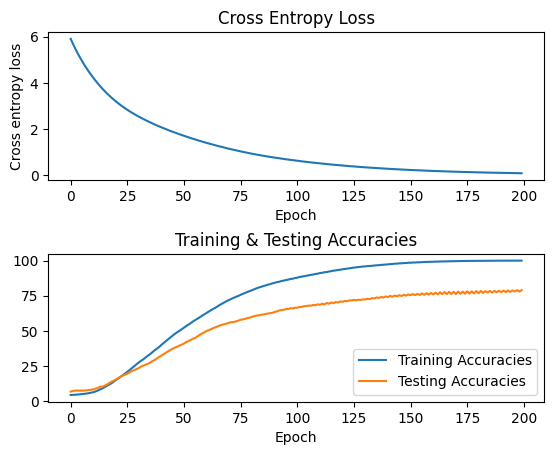

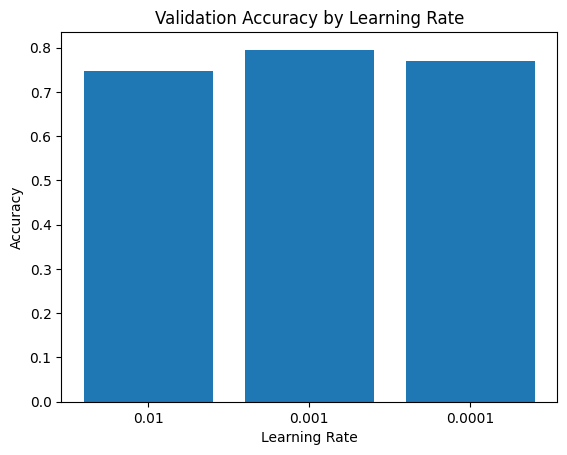

In [91]:
n_features = X_train.shape[-1]
HIDDEN_SIZE = 256
OUTPUT_SIZE = 24
GRADIENT_STEPS = 200
LEARNING_RATES = [0.01, 0.001, 0.0001]
validation_accuracy_list = []

for LEARNING_RATE in LEARNING_RATES:
  mlp2 = MLP(
      LinearLayer(n_features, HIDDEN_SIZE),
      ReLULayer(),
      LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
      ReLULayer(),
      LinearLayer(HIDDEN_SIZE, OUTPUT_SIZE),
      SoftmaxOutputLayer()
  )

  opt2 = GradientDescentOptimizer(mlp2, LEARNING_RATE, clip_value=1.0)

  train(mlp2, opt2, X_train, y_train, GRADIENT_STEPS, X_test, y_test)

  validation_accuracy = evaluate_acc(mlp2, X_validation, y_validation)
  validation_accuracy_list.append(validation_accuracy)


learning_rate_str = [str(lr) for lr in LEARNING_RATES]

plt.bar(learning_rate_str, validation_accuracy_list)

plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy by Learning Rate')
plt.xticks(learning_rate_str, LEARNING_RATES)

plt.show()

# Deciding on Clip Value

100%|██████████| 200/200 [02:03<00:00,  1.63it/s]


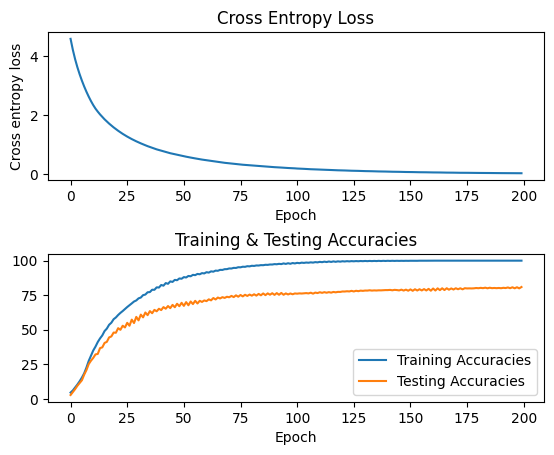

100%|██████████| 200/200 [02:07<00:00,  1.57it/s]


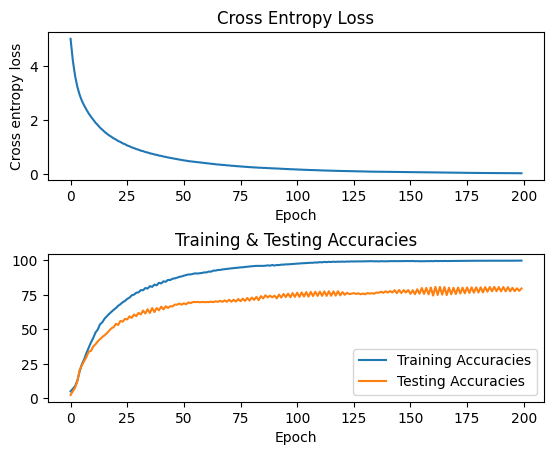

100%|██████████| 200/200 [02:04<00:00,  1.61it/s]


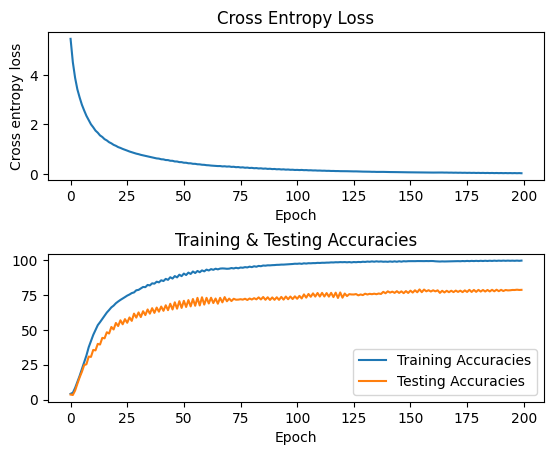

100%|██████████| 200/200 [02:08<00:00,  1.56it/s]


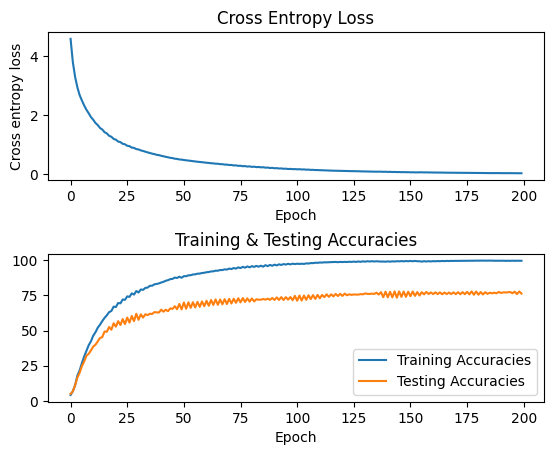

100%|██████████| 200/200 [02:11<00:00,  1.52it/s]


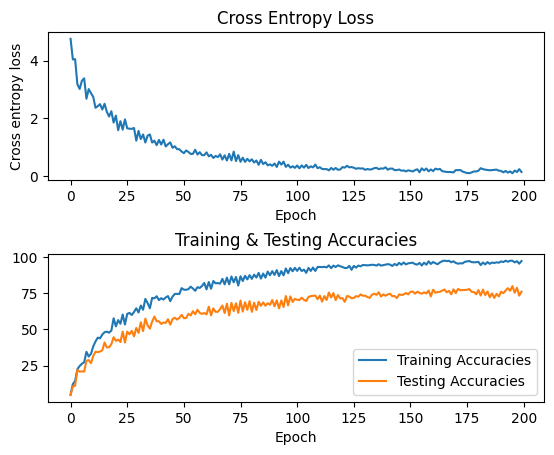

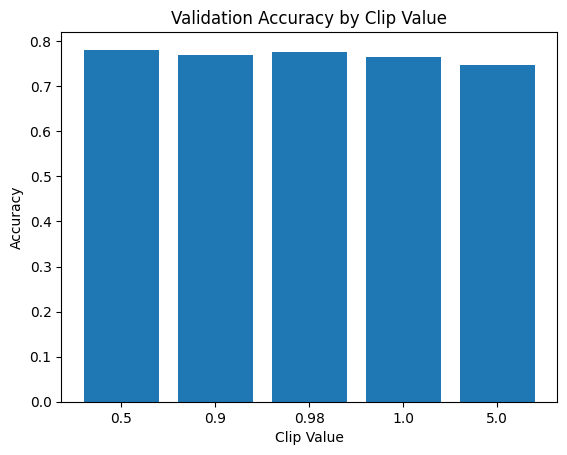

In [24]:
# even though 256 hidden units is better for accuracy, used 128 for running time purposes while deciding the hyperparameters, then going to use 256 for the actual test accuracy model

n_features = X_train.shape[-1]
HIDDEN_SIZE = 128
OUTPUT_SIZE = 24
GRADIENT_STEPS = 200
LEARNING_RATE = 0.001
validation_accuracy_list = []
CLIP_VALUES = [0.5, 0.9, 0.98, 1.0, 5.0]

for CLIP_VALUE in CLIP_VALUES:
  mlp2 = MLP(
      LinearLayer(n_features, HIDDEN_SIZE),
      ReLULayer(),
      LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
      ReLULayer(),
      LinearLayer(HIDDEN_SIZE, OUTPUT_SIZE),
      SoftmaxOutputLayer()
  )

  opt2 = GradientDescentOptimizer(mlp2, LEARNING_RATE, clip_value=CLIP_VALUE)

  train(mlp2, opt2, X_train, y_train, GRADIENT_STEPS, X_test, y_test)

  validation_accuracy = evaluate_acc(mlp2, X_validation, y_validation)
  validation_accuracy_list.append(validation_accuracy)


learning_rate_str = [str(lr) for lr in CLIP_VALUES]

plt.bar(learning_rate_str, validation_accuracy_list)

plt.xlabel('Clip Value')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy by Clip Value')
plt.xticks(learning_rate_str, CLIP_VALUES)

plt.show()

In [26]:
print(validation_accuracy_list)

[0.7810931399888456, 0.769659788064696, 0.7749581706636921, 0.7643614054657, 0.7462353597322923]


100%|██████████| 200/200 [04:05<00:00,  1.23s/it]


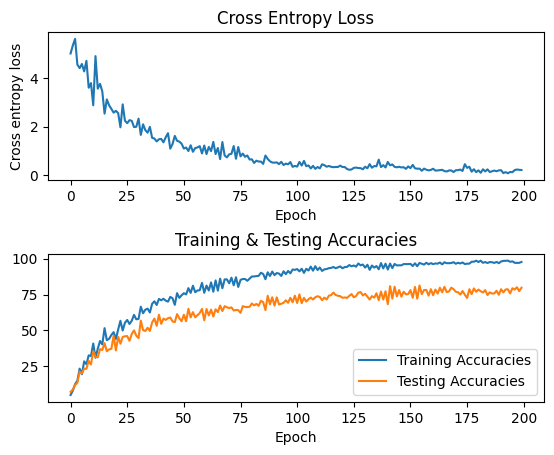

Test accuracy: 0.7805354155047407


In [28]:
#best model test accuracy for 2 hidden layer MLP

n_features = X_train.shape[-1]
HIDDEN_SIZE = 256
OUTPUT_SIZE = 24
GRADIENT_STEPS = 200
LEARNING_RATE = 0.001
validation_accuracy_list = []
CLIP_VALUES = 0.5


mlp2 = MLP(
      LinearLayer(n_features, HIDDEN_SIZE),
      ReLULayer(),
      LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
      ReLULayer(),
      LinearLayer(HIDDEN_SIZE, OUTPUT_SIZE),
      SoftmaxOutputLayer()
)

opt2 = GradientDescentOptimizer(mlp2, LEARNING_RATE, clip_value=CLIP_VALUE)
train(mlp2, opt2, X_train, y_train, GRADIENT_STEPS, X_test, y_test)

print("Test accuracy:", evaluate_acc(mlp2, X_test, y_test))

# Experiment 2

# Sigmoid Activation Layer

Hidden Unit Size: 32


100%|██████████| 500/500 [06:29<00:00,  1.28it/s]


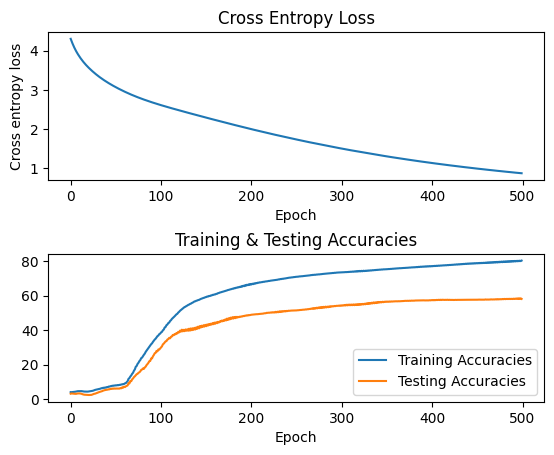

Training accuracy:  0.8010926971407758
Test accuracy: 0.5850529838259899


Hidden Unit Size: 64


100%|██████████| 500/500 [08:53<00:00,  1.07s/it]


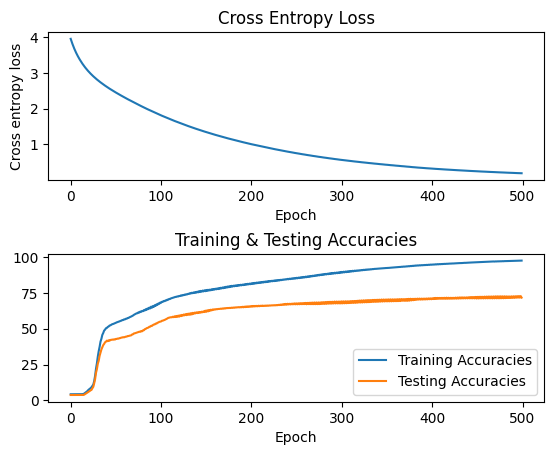

Training accuracy:  0.9753778910945183
Test accuracy: 0.7275515895147797


Hidden Unit Size: 128


100%|██████████| 500/500 [14:51<00:00,  1.78s/it]


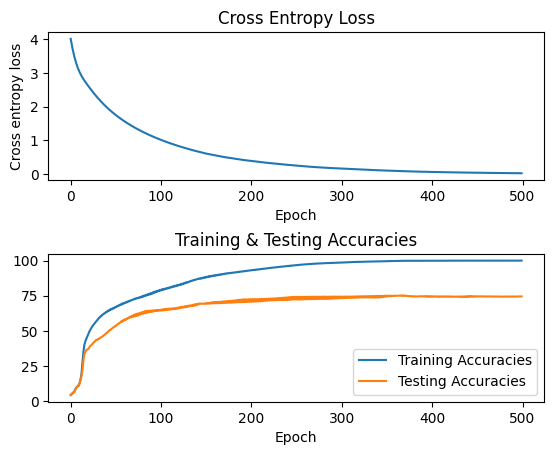

Training accuracy:  0.9995264979056638
Test accuracy: 0.7448410485220301


Hidden Unit Size: 256


100%|██████████| 500/500 [32:26<00:00,  3.89s/it]


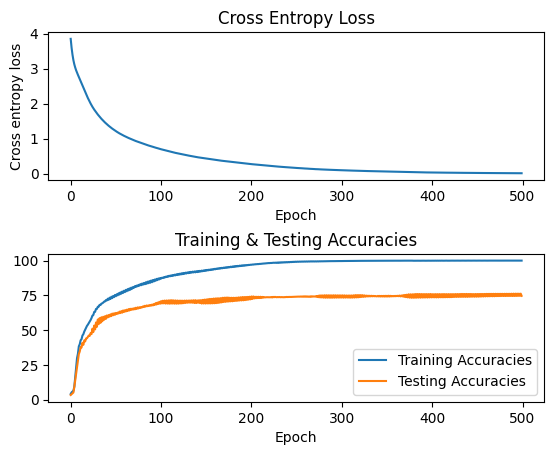

Training accuracy:  1.0
Test accuracy: 0.7625488008923592




In [41]:
n_features = X_train.shape[-1]
HIDDEN_SIZE_LIST = [32, 64, 128, 256]
OUTPUT_SIZE = 24
GRADIENT_STEPS = 500 #200 steps was not enough for the sigmoid activation layer convergence, so ran with 500
# could be an important thing to note in the model --> needs more iterations to converge with the sigmoid activation layer

for HIDDEN_SIZE in HIDDEN_SIZE_LIST:
  print("Hidden Unit Size:", HIDDEN_SIZE)
  mlp2 = MLP(
      LinearLayer(n_features, HIDDEN_SIZE),
      SigmoidLayer(),
      LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
      SigmoidLayer(),
      LinearLayer(HIDDEN_SIZE, OUTPUT_SIZE),
      SoftmaxOutputLayer()
  )
  opt2 = GradientDescentOptimizer(mlp2, 1e-3, clip_value=1.0)

  train(mlp2, opt2, X_train, y_train, GRADIENT_STEPS, X_test, y_test)
  print("Training accuracy: ", evaluate_acc(mlp2, X_train, y_train))
  print("Test accuracy:", evaluate_acc(mlp2, X_test, y_test))
  print()
  print()

  # mlp2.fit(X_train, y_train, opt2, GRADIENT_STEPS, 1e-3)

100%|██████████| 1500/1500 [06:42<00:00,  3.73it/s]


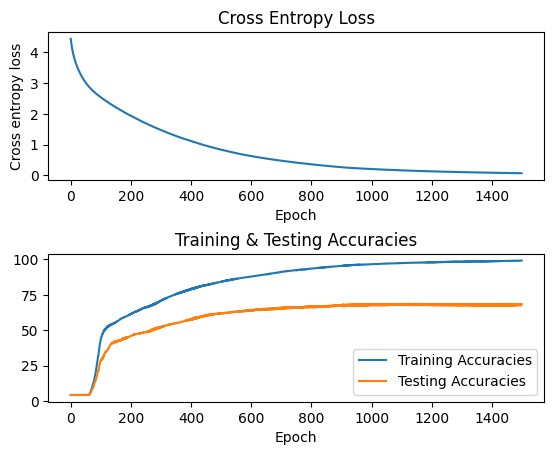

Training accuracy:  0.9912948461118194
Test accuracy: 0.675404350250976




In [29]:
# The Hidden Unit Size of 32 with the Sigmoid Activation Layer seems to not converge fully, so trying that one again with more iteration
# --> still test accuracy very bad compared to higher hidden sizes --> even though increase the iterations much more, the hidden size seems to be more improtant
n_features = X_train.shape[-1]
HIDDEN_SIZE = 32
OUTPUT_SIZE = 24
GRADIENT_STEPS = 1500


mlp2 = MLP(
  LinearLayer(n_features, HIDDEN_SIZE),
  SigmoidLayer(),
  LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
  SigmoidLayer(),
  LinearLayer(HIDDEN_SIZE, OUTPUT_SIZE),
  SoftmaxOutputLayer()
)

opt2 = GradientDescentOptimizer(mlp2, 1e-3, clip_value=1.0)

train(mlp2, opt2, X_train, y_train, GRADIENT_STEPS, X_test, y_test)
print("Training accuracy: ", evaluate_acc(mlp2, X_train, y_train))
print("Test accuracy:", evaluate_acc(mlp2, X_test, y_test))
print()
print()

# mlp2.fit(X_train, y_train, opt2, GRADIENT_STEPS, 1e-3)

# Deciding on Learning Rate

100%|██████████| 500/500 [04:31<00:00,  1.84it/s]


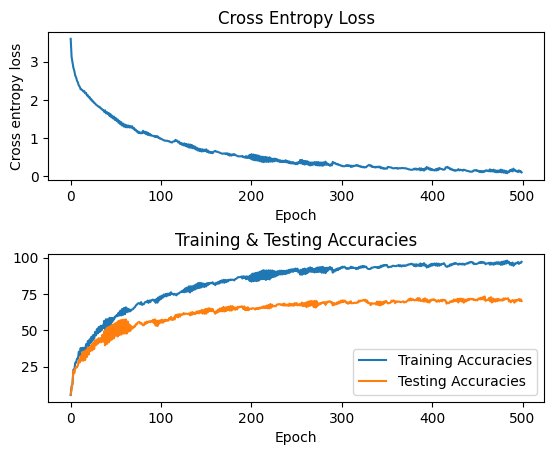

100%|██████████| 500/500 [04:22<00:00,  1.90it/s]


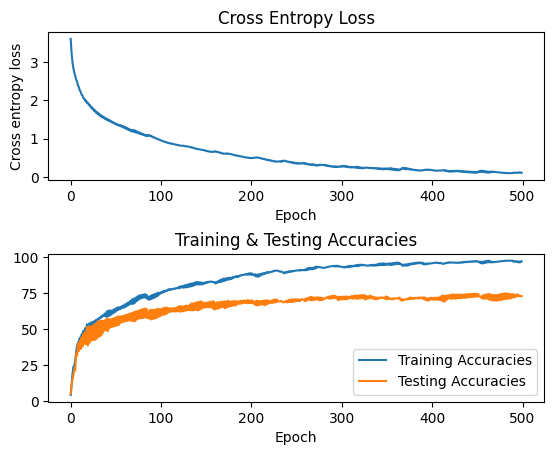

100%|██████████| 500/500 [04:24<00:00,  1.89it/s]


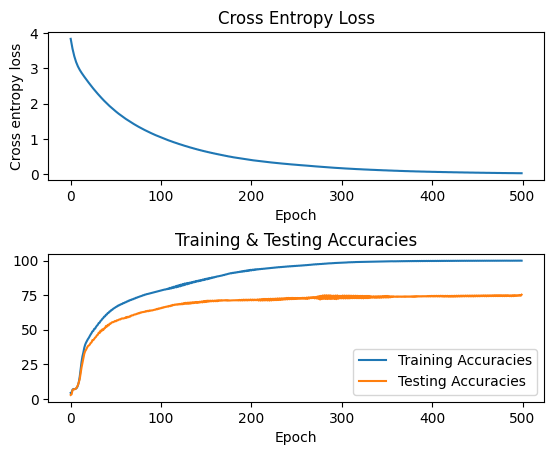

100%|██████████| 500/500 [04:24<00:00,  1.89it/s]


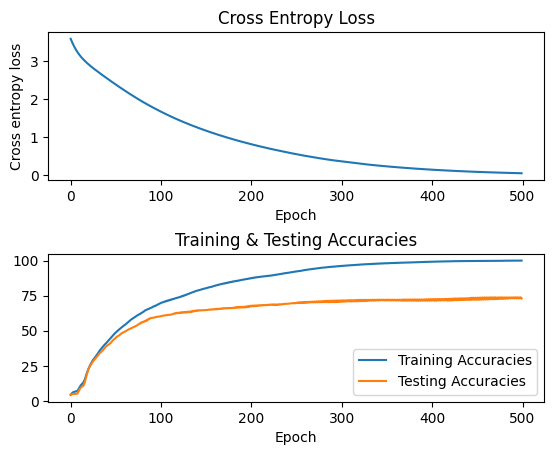

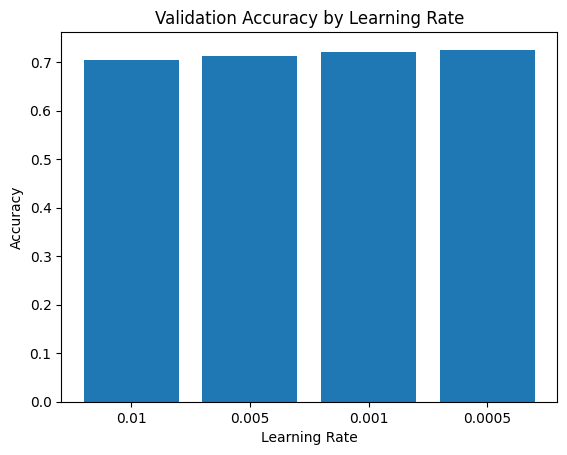

In [30]:
n_features = X_train.shape[-1]
HIDDEN_SIZE = 128
OUTPUT_SIZE = 24
GRADIENT_STEPS = 500
LEARNING_RATES = [0.01, 0.005, 0.001, 0.0005]
validation_accuracy_list = []

for LEARNING_RATE in LEARNING_RATES:
  mlp2 = MLP(
      LinearLayer(n_features, HIDDEN_SIZE),
      SigmoidLayer(),
      LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
      SigmoidLayer(),
      LinearLayer(HIDDEN_SIZE, OUTPUT_SIZE),
      SoftmaxOutputLayer()
  )

  opt2 = GradientDescentOptimizer(mlp2, LEARNING_RATE, clip_value=1.0)

  train(mlp2, opt2, X_train, y_train, GRADIENT_STEPS, X_test, y_test)

  validation_accuracy = evaluate_acc(mlp2, X_validation, y_validation)
  validation_accuracy_list.append(validation_accuracy)


learning_rate_str = [str(lr) for lr in LEARNING_RATES]

plt.bar(learning_rate_str, validation_accuracy_list)

plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy by Learning Rate')
plt.xticks(learning_rate_str, LEARNING_RATES)

plt.show()

100%|██████████| 500/500 [10:03<00:00,  1.21s/it]


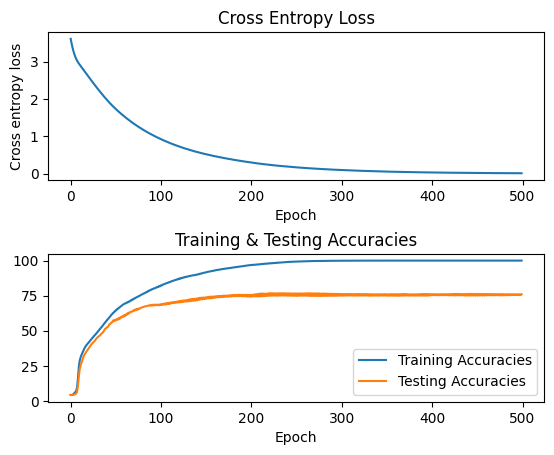

Test accuracy: 0.754601226993865


In [32]:
#best model test accuracy with sigmoid activation layer
LEARNING_RATE = 0.0005
CLIP_VALUE = 1.0
GRADIENT_STEPS = 500
HIDDEN_SIZE = 256

mlp2 = MLP(
      LinearLayer(n_features, HIDDEN_SIZE),
      SigmoidLayer(),
      LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
      SigmoidLayer(),
      LinearLayer(HIDDEN_SIZE, OUTPUT_SIZE),
      SoftmaxOutputLayer()
  )

opt2 = GradientDescentOptimizer(mlp2, LEARNING_RATE, clip_value=CLIP_VALUE)
train(mlp2, opt2, X_train, y_train, GRADIENT_STEPS, X_test, y_test)

print("Test accuracy:", evaluate_acc(mlp2, X_test, y_test))

# Leaky ReLU Layer

Hidden Unit Size: 32


100%|██████████| 200/200 [02:24<00:00,  1.38it/s]


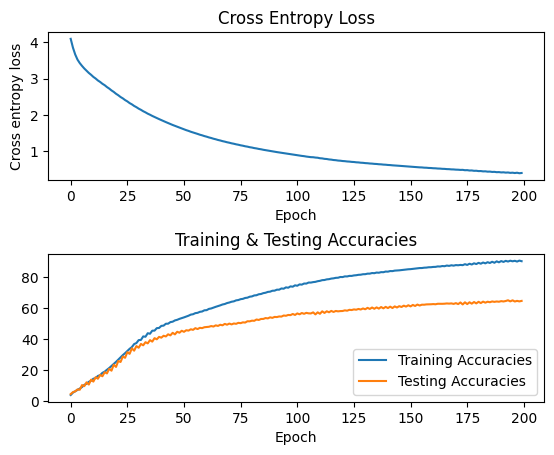

Training accuracy:  0.9070843197960299
Test accuracy: 0.644590072504183


Hidden Unit Size: 64


100%|██████████| 200/200 [03:29<00:00,  1.05s/it]


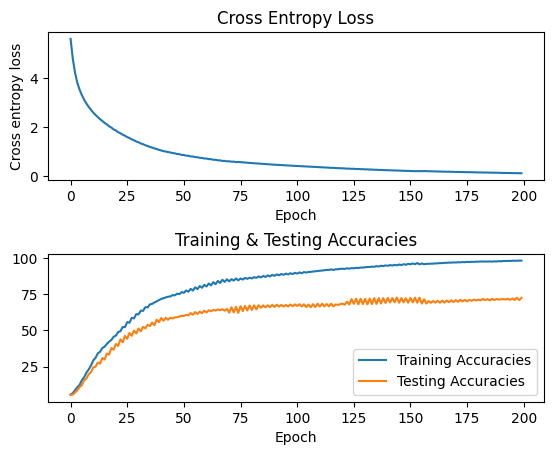

Training accuracy:  0.9813513021307594
Test accuracy: 0.7105409927495817


Hidden Unit Size: 128


100%|██████████| 200/200 [05:42<00:00,  1.71s/it]


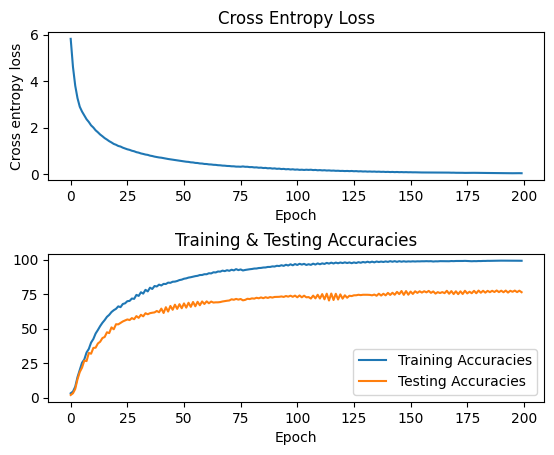

Training accuracy:  0.9920233108723365
Test accuracy: 0.7774679308421639


Hidden Unit Size: 256


100%|██████████| 200/200 [11:28<00:00,  3.44s/it]


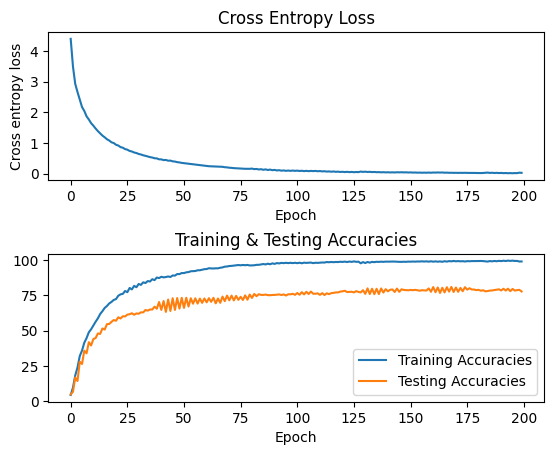

Training accuracy:  0.9906392278273538
Test accuracy: 0.7826268823201339




In [44]:
n_features = X_train.shape[-1]
HIDDEN_SIZE_LIST = [32, 64, 128, 256]
OUTPUT_SIZE = 24
GRADIENT_STEPS = 200

for HIDDEN_SIZE in HIDDEN_SIZE_LIST:
  print("Hidden Unit Size:", HIDDEN_SIZE)
  mlp2 = MLP(
      LinearLayer(n_features, HIDDEN_SIZE),
      LeakyReLULayer(),
      LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
      LeakyReLULayer(),
      LinearLayer(HIDDEN_SIZE, OUTPUT_SIZE),
      SoftmaxOutputLayer()
  )
  opt2 = GradientDescentOptimizer(mlp2, 1e-3, clip_value=1.0)

  train(mlp2, opt2, X_train, y_train, GRADIENT_STEPS, X_test, y_test)
  print("Training accuracy: ", evaluate_acc(mlp2, X_train, y_train))
  print("Test accuracy:", evaluate_acc(mlp2, X_test, y_test))
  print()
  print()

  # mlp2.fit(X_train, y_train, opt2, GRADIENT_STEPS, 1e-3)

# Deciding on Learning Rate

100%|██████████| 500/500 [05:49<00:00,  1.43it/s]


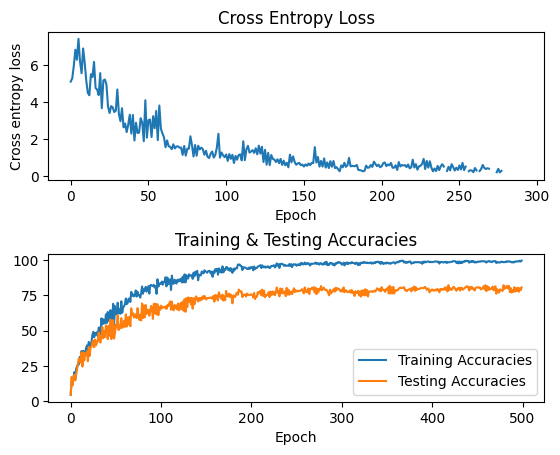

100%|██████████| 500/500 [05:49<00:00,  1.43it/s]


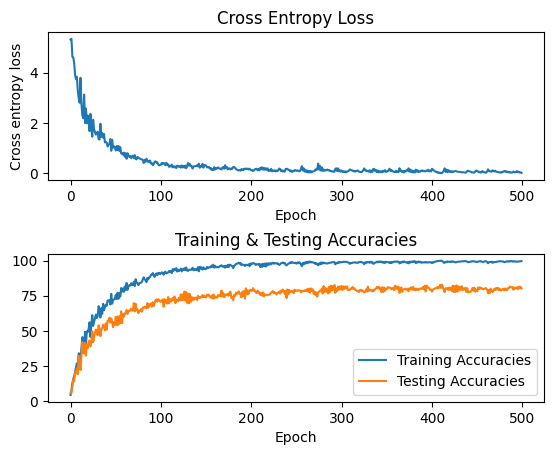

100%|██████████| 500/500 [05:44<00:00,  1.45it/s]


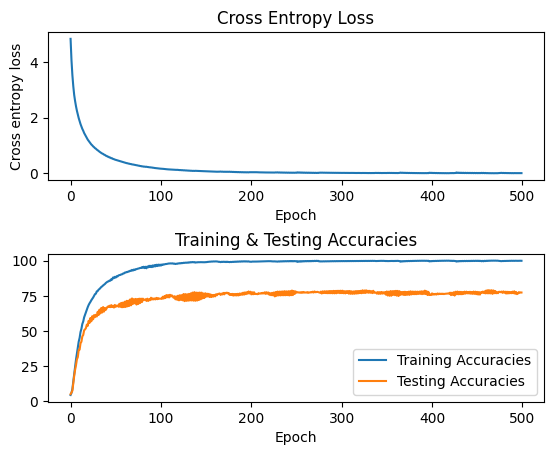

100%|██████████| 500/500 [05:43<00:00,  1.45it/s]


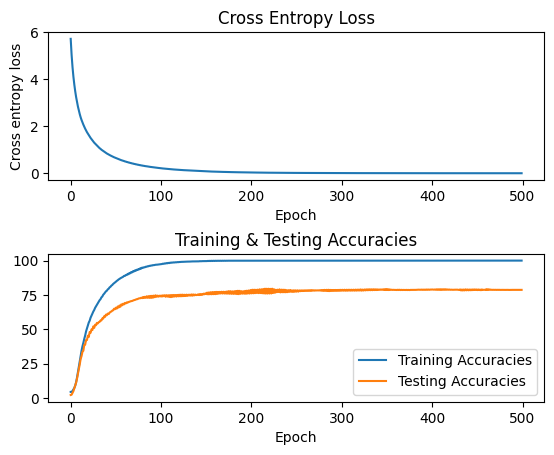

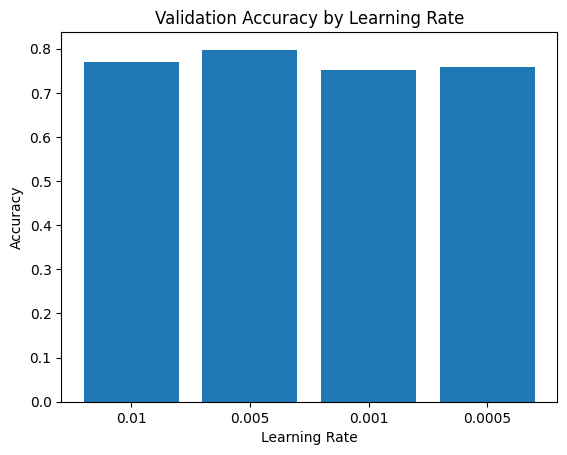

In [34]:
n_features = X_train.shape[-1]
HIDDEN_SIZE = 128
OUTPUT_SIZE = 24
GRADIENT_STEPS = 500
LEARNING_RATES = [0.01, 0.005, 0.001, 0.0005]
validation_accuracy_list = []

for LEARNING_RATE in LEARNING_RATES:
  mlp2 = MLP(
      LinearLayer(n_features, HIDDEN_SIZE),
      LeakyReLULayer(),
      LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
      LeakyReLULayer(),
      LinearLayer(HIDDEN_SIZE, OUTPUT_SIZE),
      SoftmaxOutputLayer()
  )

  opt2 = GradientDescentOptimizer(mlp2, LEARNING_RATE, clip_value=1.0)

  train(mlp2, opt2, X_train, y_train, GRADIENT_STEPS, X_test, y_test)

  validation_accuracy = evaluate_acc(mlp2, X_validation, y_validation)
  validation_accuracy_list.append(validation_accuracy)


learning_rate_str = [str(lr) for lr in LEARNING_RATES]

plt.bar(learning_rate_str, validation_accuracy_list)

plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy by Learning Rate')
plt.xticks(learning_rate_str, LEARNING_RATES)

plt.show()

100%|██████████| 500/500 [11:31<00:00,  1.38s/it]


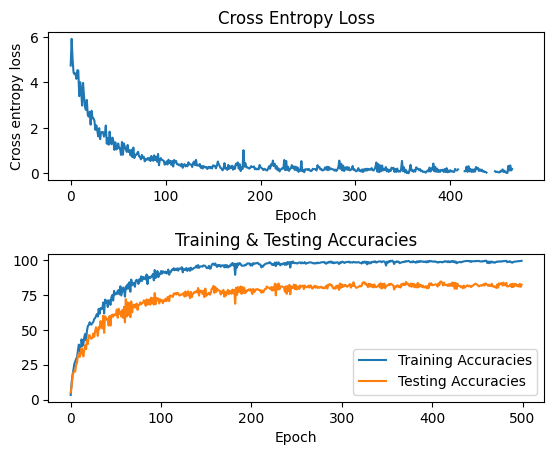

Test accuracy: 0.8070273284997211


In [39]:
#best model test accuracy with leaky relu activation layer
LEARNING_RATE = 0.005
CLIP_VALUE = 1.0
GRADIENT_STEPS = 500
HIDDEN_SIZE = 256

mlp2 = MLP(
      LinearLayer(n_features, HIDDEN_SIZE),
      LeakyReLULayer(),
      LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
      LeakyReLULayer(),
      LinearLayer(HIDDEN_SIZE, OUTPUT_SIZE),
      SoftmaxOutputLayer()
  )

opt2 = GradientDescentOptimizer(mlp2, LEARNING_RATE, clip_value=CLIP_VALUE)
train(mlp2, opt2, X_train, y_train, GRADIENT_STEPS, X_test, y_test)

print("Test accuracy:", evaluate_acc(mlp2, X_test, y_test))

# Experiment 3

# L2 regularization

# Deciding on the Lambda Value

Lambda: 1


100%|██████████| 200/200 [01:52<00:00,  1.78it/s]


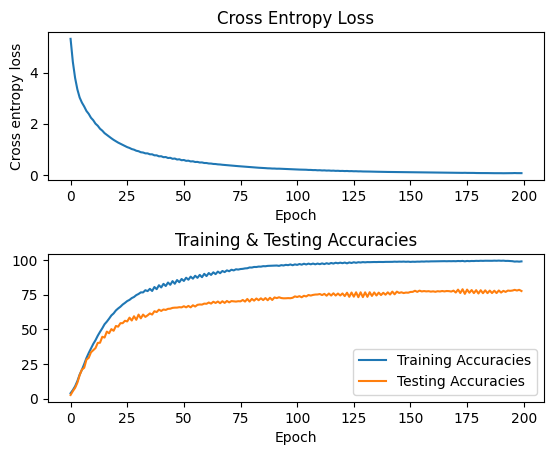

Training accuracy:  0.9901657257330176
Test accuracy: 0.7819297267150028


Lambda: 0.5


100%|██████████| 200/200 [01:51<00:00,  1.80it/s]


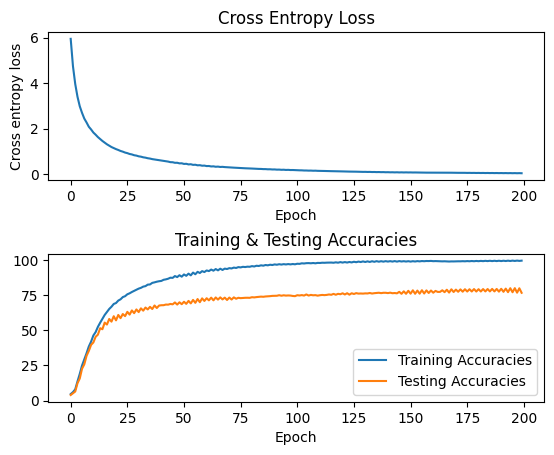

Training accuracy:  0.9946822072482243
Test accuracy: 0.800334634690463


Lambda: 0.1


100%|██████████| 200/200 [01:52<00:00,  1.77it/s]


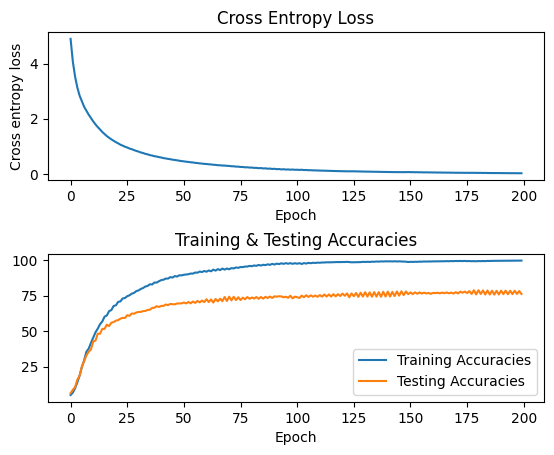

Training accuracy:  0.9977053360043708
Test accuracy: 0.7863915225878416


Lambda: 0.05


100%|██████████| 200/200 [01:52<00:00,  1.78it/s]


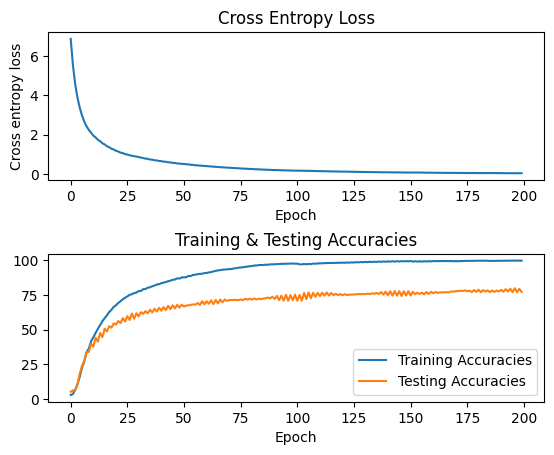

Training accuracy:  0.9962848297213622
Test accuracy: 0.786670384829894


Lambda: 0.001


100%|██████████| 200/200 [01:52<00:00,  1.78it/s]


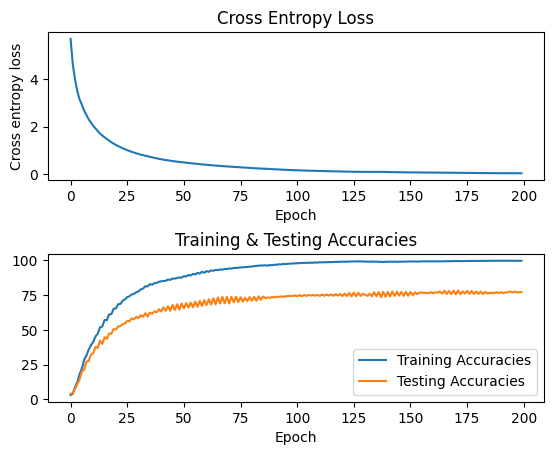

Training accuracy:  0.9963940994354398
Test accuracy: 0.7677077523703291




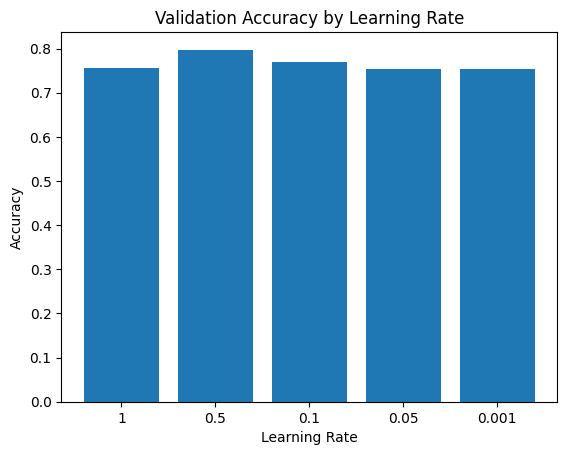

In [41]:
n_features = X_train.shape[-1]
HIDDEN_SIZE = 128
LAMBDA_LIST = [1, 0.5, 0.1, 0.05, 0.001]
OUTPUT_SIZE = 24
GRADIENT_STEPS = 200
validation_accuracy_list = []

for LAMBDA in LAMBDA_LIST:
  mlp2 = MLP(
    LinearLayer(n_features, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, OUTPUT_SIZE),
    SoftmaxOutputLayer()
  )

  print("Lambda:", LAMBDA)
  opt2 = GradientDescentOptimizer(mlp2, 1e-3, lamda=LAMBDA, clip_value=1.0)

  train(mlp2, opt2, X_train, y_train, GRADIENT_STEPS, X_test, y_test)
  validation_accuracy = evaluate_acc(mlp2, X_validation, y_validation)
  validation_accuracy_list.append(validation_accuracy)

  print("Training accuracy: ", evaluate_acc(mlp2, X_train, y_train))
  print("Test accuracy:", evaluate_acc(mlp2, X_test, y_test))
  print()
  print()

lambda_str = [str(lr) for lr in LAMBDA_LIST]

plt.bar(lambda_str, validation_accuracy_list)

plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy by Learning Rate')
plt.xticks(lambda_str, LAMBDA_LIST)

plt.show()

    # mlp2.fit(X_train, y_train, opt2, GRADIENT_STEPS, 1e-3)

# Deciding on Learning Rate

100%|██████████| 500/500 [04:43<00:00,  1.76it/s]


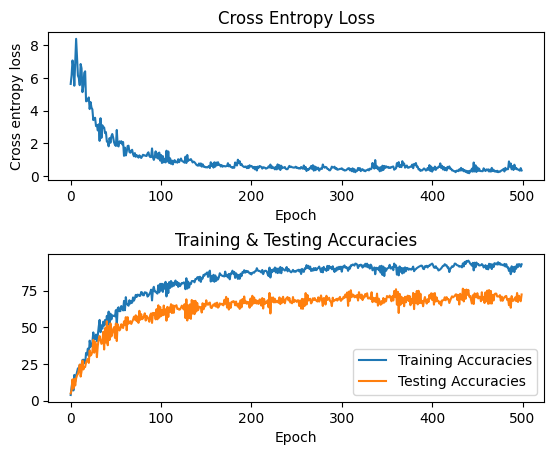

100%|██████████| 500/500 [04:46<00:00,  1.75it/s]


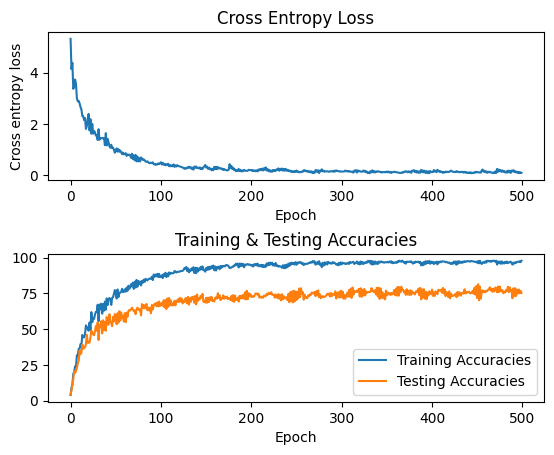

100%|██████████| 500/500 [04:37<00:00,  1.80it/s]


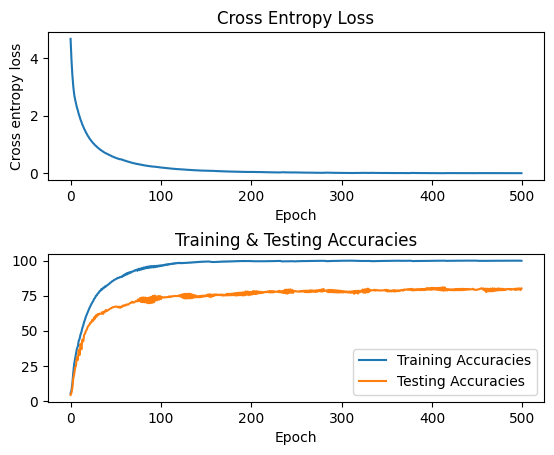

100%|██████████| 500/500 [04:38<00:00,  1.80it/s]


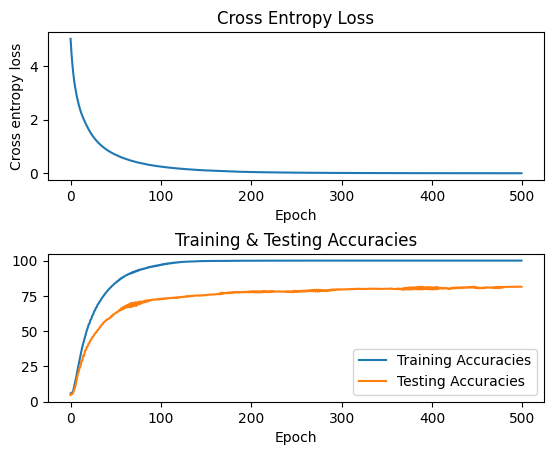

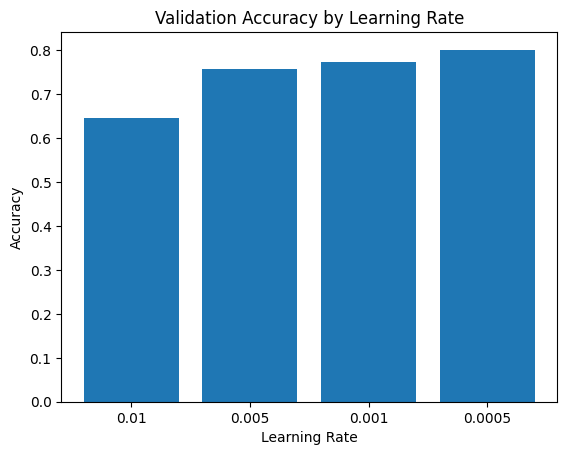

In [42]:
n_features = X_train.shape[-1]
HIDDEN_SIZE = 128
OUTPUT_SIZE = 24
GRADIENT_STEPS = 500
LEARNING_RATES = [0.01, 0.005, 0.001, 0.0005]
validation_accuracy_list = []
LAMBDA = 0.5

for LEARNING_RATE in LEARNING_RATES:
  mlp2 = MLP(
      LinearLayer(n_features, HIDDEN_SIZE),
      ReLULayer(),
      LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
      ReLULayer(),
      LinearLayer(HIDDEN_SIZE, OUTPUT_SIZE),
      SoftmaxOutputLayer()
  )

  opt2 = GradientDescentOptimizer(mlp2, LEARNING_RATE, lamda=LAMBDA, clip_value=1.0)

  train(mlp2, opt2, X_train, y_train, GRADIENT_STEPS, X_test, y_test)

  validation_accuracy = evaluate_acc(mlp2, X_validation, y_validation)
  validation_accuracy_list.append(validation_accuracy)


learning_rate_str = [str(lr) for lr in LEARNING_RATES]

plt.bar(learning_rate_str, validation_accuracy_list)

plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy by Learning Rate')
plt.xticks(learning_rate_str, LEARNING_RATES)

plt.show()

100%|██████████| 500/500 [09:10<00:00,  1.10s/it]


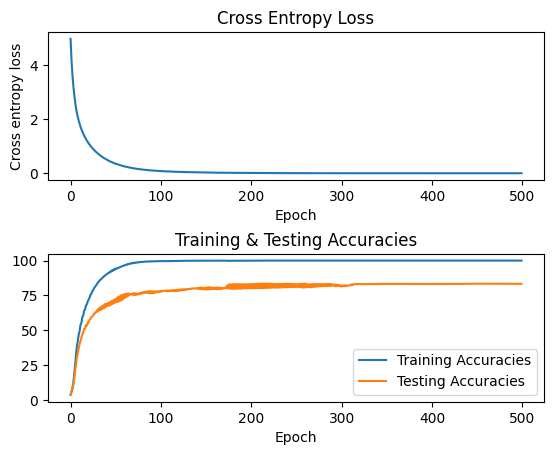

Test accuracy: 0.8340769659788064


In [43]:
#best model test accuracy with l2 regularization
LEARNING_RATE = 0.0005
LAMBDA = 0.5
CLIP_VALUE = 1.0
GRADIENT_STEPS = 500
HIDDEN_SIZE = 256

mlp2 = MLP(
      LinearLayer(n_features, HIDDEN_SIZE),
      ReLULayer(),
      LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
      ReLULayer(),
      LinearLayer(HIDDEN_SIZE, OUTPUT_SIZE),
      SoftmaxOutputLayer()
  )

opt2 = GradientDescentOptimizer(mlp2, LEARNING_RATE, lamda=LAMBDA, clip_value=CLIP_VALUE)
train(mlp2, opt2, X_train, y_train, GRADIENT_STEPS, X_test, y_test)

print("Test accuracy:", evaluate_acc(mlp2, X_test, y_test))

# Experiment 4

# CNN with 3 convolutional and 2 fully connected layers

In [12]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import MaxPool2D, Dropout, MaxPooling2D, Activation, ZeroPadding2D
from tensorflow.keras.optimizers import Adam

In [13]:
X_test.shape

(3586, 784)

In [14]:
X_train_CNN = X_train.reshape((27455, 28, 28))
y_train_CNN = y_train

X_test_CNN = X_test.reshape((3586, 28, 28))
y_test_CNN = y_test

X_validation_CNN = X_validation.reshape((3586, 28, 28))
y_validation_CNN = y_validation

print(X_train_CNN.shape)

(27455, 28, 28)


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 26, 26, 10)        100       
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 13, 13, 10)        0         
 ng2D)                                                           
                                                                 
 conv2d_28 (Conv2D)          (None, 11, 11, 10)        910       
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 5, 5, 10)          0         
 ng2D)                                                           
                                                                 
 conv2d_29 (Conv2D)          (None, 3, 3, 32)          2912      
                                                                 
 flatten_9 (Flatten)         (None, 288)              

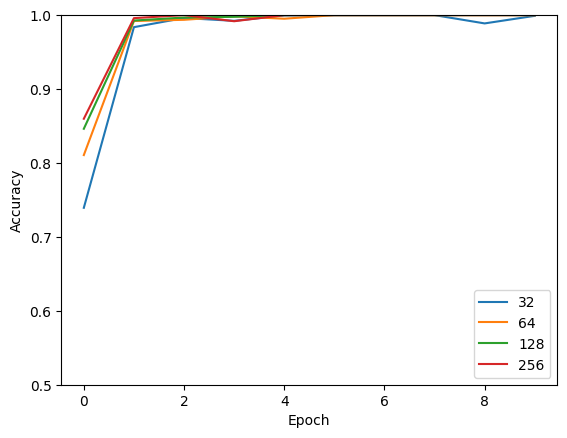

In [54]:
HIDDEN_UNIT_LIST = [32, 64, 128, 256]

for HIDDEN_UNIT in HIDDEN_UNIT_LIST:
  model = models.Sequential()
  model.add(layers.Conv2D(10, 3, activation='relu', input_shape=(28, 28, 1)))
  model.add(MaxPooling2D(pool_size=2))
  model.add(layers.Conv2D(10, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=2))
  model.add(layers.Conv2D(HIDDEN_UNIT, (3, 3), activation='relu'))
  model.add(layers.Flatten())

  model.add(layers.Dense(HIDDEN_UNIT, activation='relu'))
  model.add(layers.Dense(24, activation='softmax'))
  model.summary()

  adam = Adam(learning_rate=0.001)
  model.compile(optimizer = adam, loss='categorical_crossentropy', metrics=['accuracy'])

  print("HIDDEN UNIT:", HIDDEN_UNIT)
  history = model.fit(X_train_CNN, y_train_CNN, epochs=10)

  plt.plot(history.history['accuracy'], label=str(HIDDEN_UNIT))
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim([0.5, 1])
  plt.legend(loc='lower right')

  validation_loss, validation_accuracy = model.evaluate(X_validation_CNN,  y_validation_CNN, verbose=2)
  print("Validation Accuracy:", validation_accuracy)

plt.show()

# Deciding on Learning Rate

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_87 (Conv2D)          (None, 26, 26, 10)        100       
                                                                 
 max_pooling2d_58 (MaxPooli  (None, 13, 13, 10)        0         
 ng2D)                                                           
                                                                 
 conv2d_88 (Conv2D)          (None, 11, 11, 10)        910       
                                                                 
 max_pooling2d_59 (MaxPooli  (None, 5, 5, 10)          0         
 ng2D)                                                           
                                                                 
 conv2d_89 (Conv2D)          (None, 3, 3, 256)         23296     
                                                                 
 flatten_29 (Flatten)        (None, 2304)            

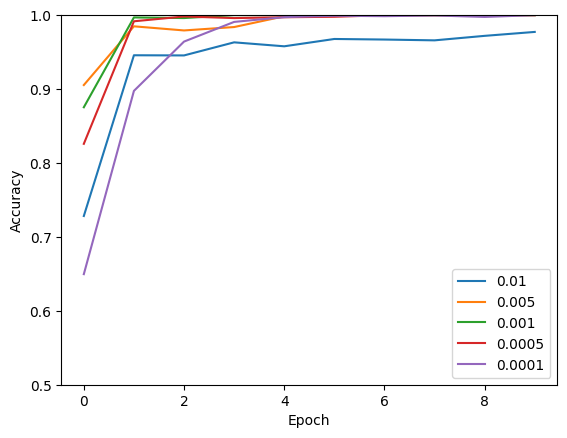

In [58]:
HIDDEN_UNIT = 256
LEARNING_RATE_LIST = [0.01, 0.005, 0.001, 0.0005, 0.0001]

for LEARNING_RATE in LEARNING_RATE_LIST:
  model = models.Sequential()
  model.add(layers.Conv2D(10, 3, activation='relu', input_shape=(28, 28, 1)))
  model.add(MaxPooling2D(pool_size=2))
  model.add(layers.Conv2D(10, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=2))
  model.add(layers.Conv2D(HIDDEN_UNIT, (3, 3), activation='relu'))
  model.add(layers.Flatten())

  model.add(layers.Dense(HIDDEN_UNIT, activation='relu'))
  model.add(layers.Dense(24, activation='softmax'))
  model.summary()

  adam = Adam(learning_rate=LEARNING_RATE)
  model.compile(optimizer = adam, loss='categorical_crossentropy', metrics=['accuracy'])

  print("HIDDEN UNIT:", HIDDEN_UNIT)
  history = model.fit(X_train_CNN, y_train_CNN, epochs=10)

  plt.plot(history.history['accuracy'], label=str(LEARNING_RATE))
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim([0.5, 1])
  plt.legend(loc='lower right')

  validation_loss, validation_accuracy = model.evaluate(X_validation_CNN,  y_validation_CNN, verbose=2)
  print("Validation Accuracy:", validation_accuracy)

plt.show()

# Max Pooling vs no Max Pooling --> Max Pooling Addition Improves Accuracy

In [62]:
HIDDEN_UNIT = 256
LEARNING_RATE = 0.001


model = models.Sequential()
model.add(layers.Conv2D(10, 3, activation='relu', input_shape=(28, 28, 1)))
model.add(layers.Conv2D(10, (3, 3), activation='relu'))
model.add(layers.Conv2D(HIDDEN_UNIT, (3, 3), activation='relu'))
model.add(layers.Flatten())

model.add(layers.Dense(HIDDEN_UNIT, activation='relu'))
model.add(layers.Dense(24, activation='softmax'))
model.summary()

adam = Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer = adam, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_CNN, y_train_CNN, epochs=10)
validation_loss, validation_accuracy = model.evaluate(X_validation_CNN,  y_validation_CNN, verbose=2)
print("Validation Accuracy:", validation_accuracy)

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_108 (Conv2D)         (None, 26, 26, 10)        100       
                                                                 
 conv2d_109 (Conv2D)         (None, 24, 24, 10)        910       
                                                                 
 conv2d_110 (Conv2D)         (None, 22, 22, 256)       23296     
                                                                 
 flatten_36 (Flatten)        (None, 123904)            0         
                                                                 
 dense_72 (Dense)            (None, 256)               31719680  
                                                                 
 dense_73 (Dense)            (None, 24)                6168      
                                                                 
Total params: 31750154 (121.12 MB)
Trainable params: 

Deciding on the Other HyperParameters of the CNN is ommited here, as they will be experimented and discussed in detail at the Experiment Extra Section.

# Experiment 5:  try to come up with an MLP architecture that performs as well as possible

Putting in all the best performing elements from the above experiments: 2 layers, hidden unit size of 256, leaky relu activation layer, l2 regularization with lambda value 0.5, clip value of 0.9, learning rate of 0.0005

100%|██████████| 500/500 [11:16<00:00,  1.35s/it]


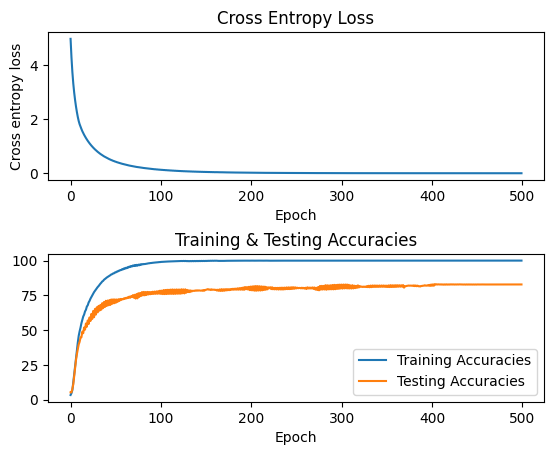

Validation accuracy: 0.7986614612381484


In [65]:
LEARNING_RATE = 0.0005
CLIP_VALUE = 0.9
GRADIENT_STEPS = 500
HIDDEN_SIZE = 256
LAMBDA = 0.5
CLIP_VALUE = 0.9

mlp2 = MLP(
      LinearLayer(n_features, HIDDEN_SIZE),
      LeakyReLULayer(),
      LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
      LeakyReLULayer(),
      LinearLayer(HIDDEN_SIZE, OUTPUT_SIZE),
      SoftmaxOutputLayer()
  )

opt2 = GradientDescentOptimizer(mlp2, LEARNING_RATE, lamda=LAMBDA, clip_value=CLIP_VALUE)
train(mlp2, opt2, X_train, y_train, GRADIENT_STEPS, X_test, y_test)

print("Validation accuracy:", evaluate_acc(mlp2, X_validation, y_validation))

however, this actually did not give the best result, so trying with clip value of 1, as the below combination, but just Relu instead of Leaky Relu performed 0.83 before

100%|██████████| 500/500 [11:12<00:00,  1.34s/it]


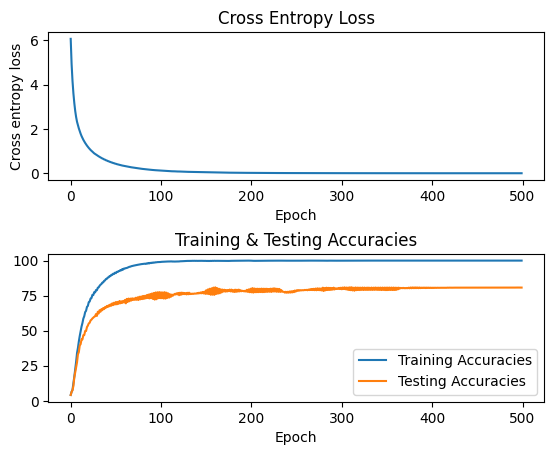

Validation accuracy: 0.7875069715560513


In [66]:
LEARNING_RATE = 0.0005
LAMBDA = 0.5
CLIP_VALUE = 1.0
GRADIENT_STEPS = 500
HIDDEN_SIZE = 256

mlp2 = MLP(
      LinearLayer(n_features, HIDDEN_SIZE),
      LeakyReLULayer(),
      LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
      LeakyReLULayer(),
      LinearLayer(HIDDEN_SIZE, OUTPUT_SIZE),
      SoftmaxOutputLayer()
  )

opt2 = GradientDescentOptimizer(mlp2, LEARNING_RATE, lamda=LAMBDA, clip_value=CLIP_VALUE)
train(mlp2, opt2, X_train, y_train, GRADIENT_STEPS, X_test, y_test)

print("Validation accuracy:", evaluate_acc(mlp2, X_validation, y_validation))

this was the best performing model in the above experiments, adding it the good performed Leaky Relu ,against my expectation, decreased the validation accuracy. will now try to increase by taking this model as my base model

100%|██████████| 500/500 [09:52<00:00,  1.19s/it]


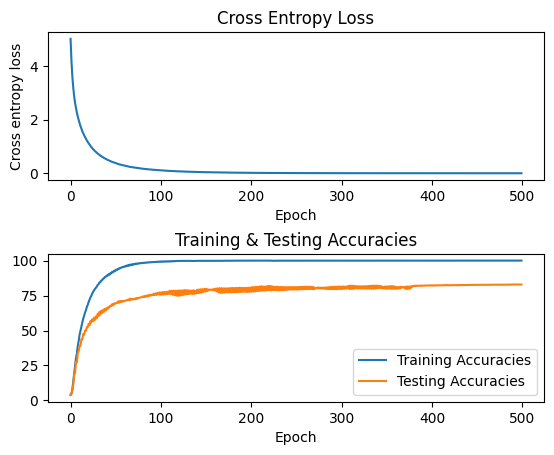

Validation accuracy: 0.8078639152258784


In [67]:
LEARNING_RATE = 0.0005
LAMBDA = 0.5
CLIP_VALUE = 1.0
GRADIENT_STEPS = 500
HIDDEN_SIZE = 256

mlp2 = MLP(
      LinearLayer(n_features, HIDDEN_SIZE),
      ReLULayer(),
      LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
      ReLULayer(),
      LinearLayer(HIDDEN_SIZE, OUTPUT_SIZE),
      SoftmaxOutputLayer()
  )

opt2 = GradientDescentOptimizer(mlp2, LEARNING_RATE, lamda=LAMBDA, clip_value=CLIP_VALUE)
train(mlp2, opt2, X_train, y_train, GRADIENT_STEPS, X_test, y_test)

print("Validation accuracy:", evaluate_acc(mlp2, X_validation, y_validation))

100%|██████████| 500/500 [17:34<00:00,  2.11s/it]


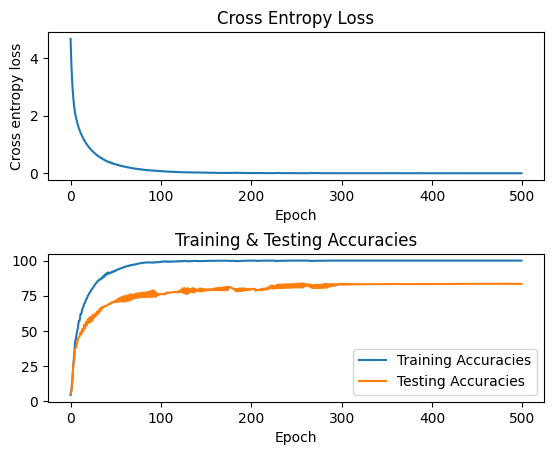

Validation accuracy: 0.8089793641940881


In [68]:
LEARNING_RATE = 0.0005
LAMBDA = 0.5
CLIP_VALUE = 1.0
GRADIENT_STEPS = 500
HIDDEN_SIZE = 512

mlp2 = MLP(
      LinearLayer(n_features, HIDDEN_SIZE),
      ReLULayer(),
      LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
      ReLULayer(),
      LinearLayer(HIDDEN_SIZE, OUTPUT_SIZE),
      SoftmaxOutputLayer()
  )

opt2 = GradientDescentOptimizer(mlp2, LEARNING_RATE, lamda=LAMBDA, clip_value=CLIP_VALUE)
train(mlp2, opt2, X_train, y_train, GRADIENT_STEPS, X_test, y_test)

print("Validation accuracy:", evaluate_acc(mlp2, X_validation, y_validation))

100%|██████████| 500/500 [25:21<00:00,  3.04s/it]


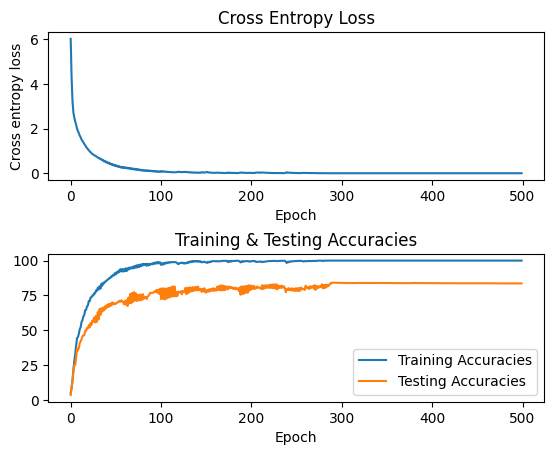

Validation accuracy: 0.8198549916341328


In [69]:
LEARNING_RATE = 0.0005
LAMBDA = 0.5
CLIP_VALUE = 1.0
GRADIENT_STEPS = 500
HIDDEN_SIZE = 512

mlp2 = MLP(
      LinearLayer(n_features, HIDDEN_SIZE),
      ReLULayer(),
      LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
      ReLULayer(),
      LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
      ReLULayer(),
      LinearLayer(HIDDEN_SIZE, OUTPUT_SIZE),
      SoftmaxOutputLayer()
  )

opt2 = GradientDescentOptimizer(mlp2, LEARNING_RATE, lamda=LAMBDA, clip_value=CLIP_VALUE)
train(mlp2, opt2, X_train, y_train, GRADIENT_STEPS, X_test, y_test)

print("Validation accuracy:", evaluate_acc(mlp2, X_validation, y_validation))

above is the best model so far

100%|██████████| 500/500 [13:37<00:00,  1.64s/it]


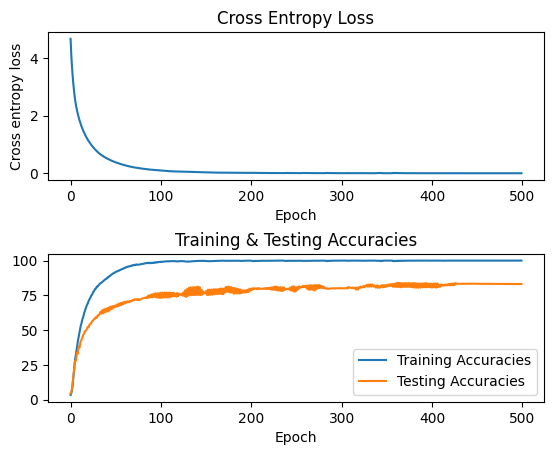

Validation accuracy: 0.8031232571109872


In [70]:
LEARNING_RATE = 0.0005
LAMBDA = 0.5
CLIP_VALUE = 1.0
GRADIENT_STEPS = 500
HIDDEN_SIZE = 256

mlp2 = MLP(
      LinearLayer(n_features, HIDDEN_SIZE),
      ReLULayer(),
      LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
      ReLULayer(),
      LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
      ReLULayer(),
      LinearLayer(HIDDEN_SIZE, OUTPUT_SIZE),
      SoftmaxOutputLayer()
  )

opt2 = GradientDescentOptimizer(mlp2, LEARNING_RATE, lamda=LAMBDA, clip_value=CLIP_VALUE)
train(mlp2, opt2, X_train, y_train, GRADIENT_STEPS, X_test, y_test)

print("Validation accuracy:", evaluate_acc(mlp2, X_validation, y_validation))

100%|██████████| 500/500 [14:13<00:00,  1.71s/it]


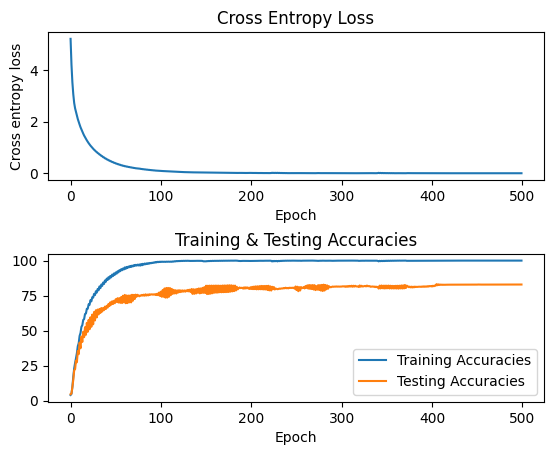

Validation accuracy: 0.8020078081427775


In [71]:
LEARNING_RATE = 0.0005
LAMBDA = 0.5
CLIP_VALUE = 1.0
GRADIENT_STEPS = 500
HIDDEN_SIZE = 256

mlp2 = MLP(
      LinearLayer(n_features, HIDDEN_SIZE),
      ReLULayer(),
      LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
      ReLULayer(),
      LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
      LeakyReLULayer(),
      LinearLayer(HIDDEN_SIZE, OUTPUT_SIZE),
      SoftmaxOutputLayer()
  )

opt2 = GradientDescentOptimizer(mlp2, LEARNING_RATE, lamda=LAMBDA, clip_value=CLIP_VALUE)
train(mlp2, opt2, X_train, y_train, GRADIENT_STEPS, X_test, y_test)

print("Validation accuracy:", evaluate_acc(mlp2, X_validation, y_validation))

100%|██████████| 500/500 [10:26<00:00,  1.25s/it]


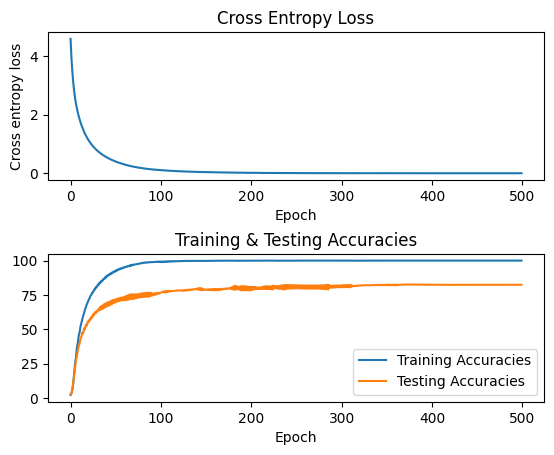

Validation accuracy: 0.8045175683212493


In [72]:
LEARNING_RATE = 0.0005
LAMBDA = 0.5
CLIP_VALUE = 1.0
GRADIENT_STEPS = 500
HIDDEN_SIZE = 256

mlp2 = MLP(
      LinearLayer(n_features, HIDDEN_SIZE),
      ReLULayer(),
      LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
      LeakyReLULayer(),
      LinearLayer(HIDDEN_SIZE, OUTPUT_SIZE),
      SoftmaxOutputLayer()
  )

opt2 = GradientDescentOptimizer(mlp2, LEARNING_RATE, lamda=LAMBDA, clip_value=CLIP_VALUE)
train(mlp2, opt2, X_train, y_train, GRADIENT_STEPS, X_test, y_test)

print("Validation accuracy:", evaluate_acc(mlp2, X_validation, y_validation))

100%|██████████| 500/500 [10:33<00:00,  1.27s/it]


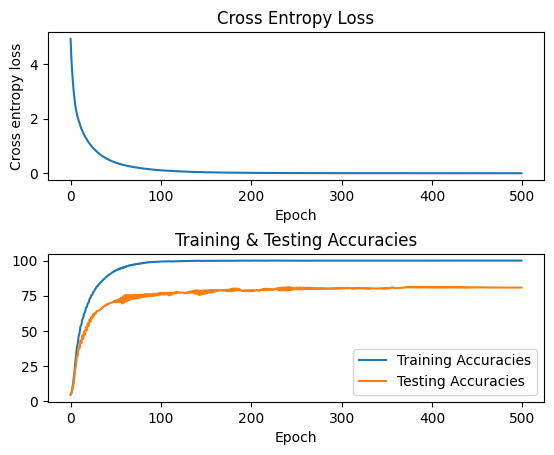

Validation accuracy: 0.7883435582822086


In [73]:
LEARNING_RATE = 0.0005
LAMBDA = 0.5
CLIP_VALUE = 1.0
GRADIENT_STEPS = 500
HIDDEN_SIZE = 256

mlp2 = MLP(
      LinearLayer(n_features, HIDDEN_SIZE),
      LeakyReLULayer(),
      LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
      ReLULayer(),
      LinearLayer(HIDDEN_SIZE, OUTPUT_SIZE),
      SoftmaxOutputLayer()
  )

opt2 = GradientDescentOptimizer(mlp2, LEARNING_RATE, lamda=LAMBDA, clip_value=CLIP_VALUE)
train(mlp2, opt2, X_train, y_train, GRADIENT_STEPS, X_test, y_test)

print("Validation accuracy:", evaluate_acc(mlp2, X_validation, y_validation))

tried many different MLP architecture and parameters, but the above model with simple architecture that was already tried in the first experiments is the best one i could came up with, with a validation accuray of 82%. It is still not as good as the CNN model

# Experiment Extra:  investigate the effect of the ConvNets’ hyperparameters related to their convolutional layers (number of filters, filter size, stride, padding, . . . ) on its test accuracy.

# Number of Filters

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 26, 26, 5)         50        
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 13, 13, 5)         0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 11, 11, 5)         230       
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 5, 5, 5)           0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 3, 3, 64)          2944      
                                                                 
 flatten_8 (Flatten)         (None, 576)              

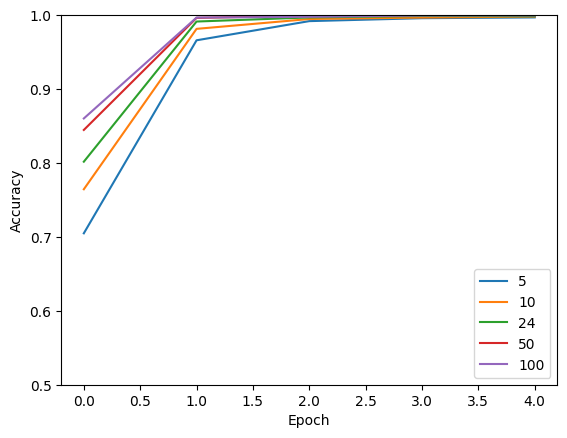

In [17]:
HIDDEN_UNIT = 64 #decreased the hidden unit and epoch sizes for time

NUMBER_OF_FILTERS = [5, 10, 24, 50, 100]
for NUMBER_OF_FILTER in NUMBER_OF_FILTERS:
  model = models.Sequential()
  model.add(layers.Conv2D(NUMBER_OF_FILTER, 3, activation='relu', input_shape=(28, 28, 1)))
  model.add(MaxPooling2D(pool_size=2))
  model.add(layers.Conv2D(NUMBER_OF_FILTER, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=2))
  model.add(layers.Conv2D(HIDDEN_UNIT, (3, 3), activation='relu'))
  model.add(layers.Flatten())

  model.add(layers.Dense(HIDDEN_UNIT, activation='relu'))
  model.add(layers.Dense(24, activation='softmax'))
  model.summary()

  model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

  print("NUMBER OF FILTER UNIT:", NUMBER_OF_FILTER)
  history = model.fit(X_train_CNN, y_train_CNN, epochs=5)

  plt.plot(history.history['accuracy'], label=str(NUMBER_OF_FILTER))
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim([0.5, 1])
  plt.legend(loc='lower right')

  test_loss, test_acc = model.evaluate(X_test_CNN,  y_test_CNN, verbose=2)
  print("Test Accuracy:", test_acc)

  print()
  print()

# Kernel Size

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 100)       200       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 100)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 100)       10100     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 100)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          6464      
                                                                 
 flatten (Flatten)           (None, 3136)              0

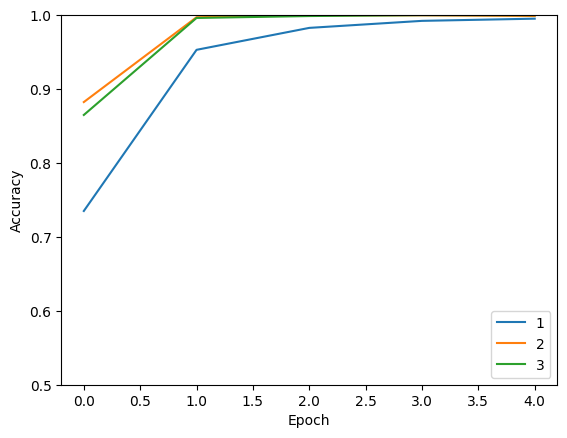

In [15]:
HIDDEN_UNIT = 64 #decreased the hidden unit and epoch sizes for time
#using the best parameter from the previous cell going forward
NUMBER_OF_FILTERS = 100

KERNEL_SIZES = [1, 2, 3]
for KERNEL_SIZE in KERNEL_SIZES:
  model = models.Sequential()
  model.add(layers.Conv2D(NUMBER_OF_FILTERS, KERNEL_SIZE, activation='relu', input_shape=(28, 28, 1)))
  model.add(MaxPooling2D(pool_size=2))
  model.add(layers.Conv2D(NUMBER_OF_FILTERS, KERNEL_SIZE, activation='relu'))
  model.add(MaxPooling2D(pool_size=2))
  model.add(layers.Conv2D(HIDDEN_UNIT, KERNEL_SIZE, activation='relu'))
  model.add(layers.Flatten())

  model.add(layers.Dense(HIDDEN_UNIT, activation='relu'))
  model.add(layers.Dense(24, activation='softmax'))
  model.summary()

  model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

  print("KERNEL SIZE:", KERNEL_SIZE)
  history = model.fit(X_train_CNN, y_train_CNN, epochs=5)

  plt.plot(history.history['accuracy'], label=str(KERNEL_SIZE))
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim([0.5, 1])
  plt.legend(loc='lower right')

  test_loss, test_acc = model.evaluate(X_test_CNN,  y_test_CNN, verbose=2)
  print("Test Accuracy:", test_acc)

  print()
  print()

# Stride

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 28, 28, 24)        48        
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 28, 28, 24)        0         
 ng2D)                                                           
                                                                 
 conv2d_34 (Conv2D)          (None, 28, 28, 24)        600       
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 28, 28, 24)        0         
 ng2D)                                                           
                                                                 
 conv2d_35 (Conv2D)          (None, 28, 28, 64)        1600      
                                                                 
 flatten_8 (Flatten)         (None, 50176)           

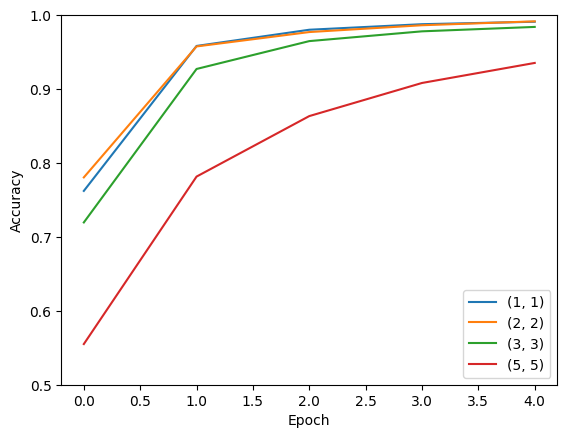

In [21]:
#When i tried to apply the stride in multiple layers and/or use it together with the maxPooling/kernel size anything beyond
#1 gave me dimension error because I think it was making the image too little ie. after few layers it reduced less than a single pixel
#so just to demonstrate the stride's effect on its own I made everything else 1 basically --> kernel size and maxPooling size are 1 in this experiment
#and just used stride in one layer

HIDDEN_UNIT = 64 #decreased the hidden unit and epoch sizes for time
NUMBER_OF_FILTERS = 24
KERNEL_SIZE = 1

STRIDES = [(1, 1), (2, 2), (3, 3), (5, 5)]
for STRIDE in STRIDES:
  model = models.Sequential()
  model.add(layers.Conv2D(NUMBER_OF_FILTERS, KERNEL_SIZE, strides = STRIDE, activation='relu', input_shape=(28, 28, 1)))
  model.add(MaxPooling2D(pool_size=1))
  model.add(layers.Conv2D(NUMBER_OF_FILTERS, KERNEL_SIZE, activation='relu'))
  model.add(MaxPooling2D(pool_size=1))
  model.add(layers.Conv2D(HIDDEN_UNIT, KERNEL_SIZE, activation='relu'))
  model.add(layers.Flatten())

  model.add(layers.Dense(HIDDEN_UNIT, activation='relu'))
  model.add(layers.Dense(24, activation='softmax'))
  model.summary()

  model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

  print("STRIDE:", STRIDE)
  history = model.fit(X_train_CNN, y_train_CNN, epochs=5)

  plt.plot(history.history['accuracy'], label=str(STRIDE))
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim([0.5, 1])
  plt.legend(loc='lower right')

  test_loss, test_acc = model.evaluate(X_test_CNN,  y_test_CNN, verbose=2)
  print("Test Accuracy:", test_acc)

  print()
  print()

stride actually decreased the accuracy, and going off of the dimension error I previously received, I think our starting input images are already not that big, so adding strides make it too small too soon and therefore not letting the model to learn much

# Padding

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_51 (Conv2D)          (None, 26, 26, 24)        240       
                                                                 
 max_pooling2d_34 (MaxPooli  (None, 13, 13, 24)        0         
 ng2D)                                                           
                                                                 
 conv2d_52 (Conv2D)          (None, 11, 11, 24)        5208      
                                                                 
 max_pooling2d_35 (MaxPooli  (None, 5, 5, 24)          0         
 ng2D)                                                           
                                                                 
 conv2d_53 (Conv2D)          (None, 3, 3, 64)          13888     
                                                                 
 flatten_14 (Flatten)        (None, 576)             

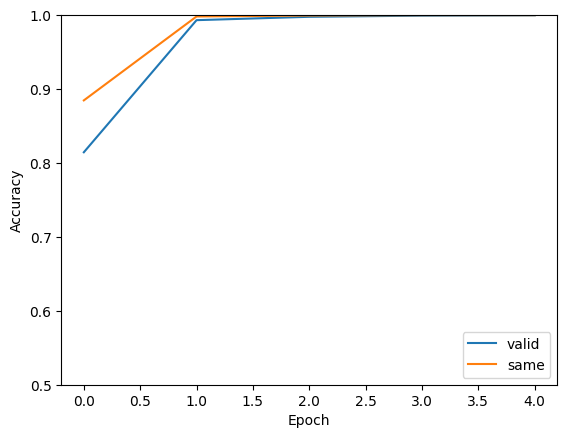

In [23]:
HIDDEN_UNIT = 64 #decreased the hidden unit and epoch sizes for time
NUMBER_OF_FILTERS = 24
KERNEL_SIZE = 3

PADDINGS = ["valid", "same"]
for PADDING in PADDINGS:
  model = models.Sequential()
  model.add(layers.Conv2D(NUMBER_OF_FILTERS, KERNEL_SIZE, padding=PADDING, activation='relu', input_shape=(28, 28, 1)))
  model.add(MaxPooling2D(pool_size=2))
  model.add(layers.Conv2D(NUMBER_OF_FILTERS, KERNEL_SIZE, padding=PADDING, activation='relu'))
  model.add(MaxPooling2D(pool_size=2))
  model.add(layers.Conv2D(HIDDEN_UNIT, KERNEL_SIZE, padding=PADDING, activation='relu'))
  model.add(layers.Flatten())

  model.add(layers.Dense(HIDDEN_UNIT, activation='relu'))
  model.add(layers.Dense(24, activation='softmax'))
  model.summary()

  model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

  print("PADDING:", PADDING)
  history = model.fit(X_train_CNN, y_train_CNN, epochs=5)

  plt.plot(history.history['accuracy'], label=PADDING)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim([0.5, 1])
  plt.legend(loc='lower right')

  test_loss, test_acc = model.evaluate(X_test_CNN,  y_test_CNN, verbose=2)
  print("Test Accuracy:", test_acc)

  print()
  print()

# Leaky Relu as Activation Function

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 26, 26, 24)        240       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 13, 13, 24)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 11, 11, 24)        5208      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 5, 5, 24)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 3, 3, 64)          13888     
                                                                 
 flatten_2 (Flatten)         (None, 576)              

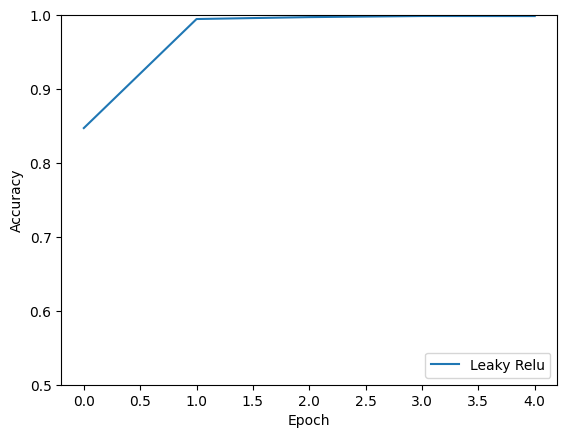

In [18]:
HIDDEN_UNIT = 64 #decreased the hidden unit and epoch sizes for time
NUMBER_OF_FILTERS = 24
KERNEL_SIZE = 3


model = models.Sequential()
model.add(layers.Conv2D(NUMBER_OF_FILTERS, KERNEL_SIZE, activation='leaky_relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=2))
model.add(layers.Conv2D(NUMBER_OF_FILTERS, KERNEL_SIZE, activation='leaky_relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(layers.Conv2D(HIDDEN_UNIT, KERNEL_SIZE, activation='leaky_relu'))
model.add(layers.Flatten())

model.add(layers.Dense(HIDDEN_UNIT, activation='leaky_relu'))
model.add(layers.Dense(24, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_CNN, y_train_CNN, epochs=5)

plt.plot(history.history['accuracy'], label="Leaky Relu")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test_CNN,  y_test_CNN, verbose=2)
print("Test Accuracy:", test_acc)

print()
print()

Normal Relu accuracy was 0.94, in contrast. So in this case Leaky Relu did not improve, but 0.003 decrease is not that significant either, so no significant impact